<a href="https://colab.research.google.com/github/okanckaya/Pima-Indians-Diabetes-Prediction/blob/main/Diabetes_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
df = pd.read_csv('gdrive/My Drive/VBO/Hafta 7/Ders Notları/diabetes.csv', error_bad_lines=False)

In [4]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [6]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

During pregnancy, some women have such high levels of blood glucose that their body is unable to produce enough insulin to absorb it all. This is known as gestational diabetes.

* https://www.nhs.uk/conditions/diabetes/

In [ ]:
glucose_labels = ['0_18', '19_23', '24_30', '31_40', '41_' + str(int(df["Age"].max()))]
df["Glucose_qcut"] = pd.qcut(df['Glucose'], 3, labels=glucose_labels)

**Oral Glucose Tolerance Test (OGTT)**

The OGTT is a two-hour test that checks your blood sugar levels before and two hours after you drink a special sweet drink. It tells the doctor how your body processes sugar.


Diabetes is diagnosed at 2 hour blood sugar of greater than or equal to 200 mg/dl


*Oral Glucose Tolerance Test (OGTT)*
*   less than 140 mg/dl -- Normal
*   140 mg/dl to 199 mg/dl -- Prediabetes
*   200 mg/dl or higher -- Diabetes

In [72]:
df.loc[(df['Glucose'] < 140), 'OGTT'] = 'Normal'
df.loc[((140 <= df['Glucose']) & (df['Glucose'] <= 199)), 'OGTT'] = 'Prediabetes'
df.loc[(df['Glucose'] > 199), 'OGTT'] = 'Diabetes'
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,OGTT
0,6,148,72,35,0,33.6,0.627,50,1,Prediabetes
1,1,85,66,29,0,26.6,0.351,31,0,Normal
2,8,183,64,0,0,23.3,0.672,32,1,Prediabetes
3,1,89,66,23,94,28.1,0.167,21,0,Normal
4,0,137,40,35,168,43.1,2.288,33,1,Normal
...,...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0,Normal
764,2,122,70,27,0,36.8,0.340,27,0,Normal
765,5,121,72,23,112,26.2,0.245,30,0,Normal
766,1,126,60,0,0,30.1,0.349,47,1,Normal


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,OGTT_Normal,OGTT_Prediabetes,Outcome_0,Outcome_1
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,-0.131509,0.131509,-0.221898,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,-0.786815,0.786815,-0.466581,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,-0.140920,0.140920,-0.065068,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,-0.089647,0.089647,-0.074752,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,-0.284868,0.284868,-0.130548,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,-0.219281,0.219281,-0.292695,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,-0.109177,0.109177,-0.173844,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,-0.244703,0.244703,-0.238356,0.238356
OGTT_Normal,-0.131509,-0.786815,-0.140920,-0.089647,-0.284868,-0.219281,-0.109177,-0.244703,1.000000,-1.000000,0.414455,-0.414455
OGTT_Prediabetes,0.131509,0.786815,0.140920,0.089647,0.284868,0.219281,0.109177,0.244703,-1.000000,1.000000,-0.414455,0.414455


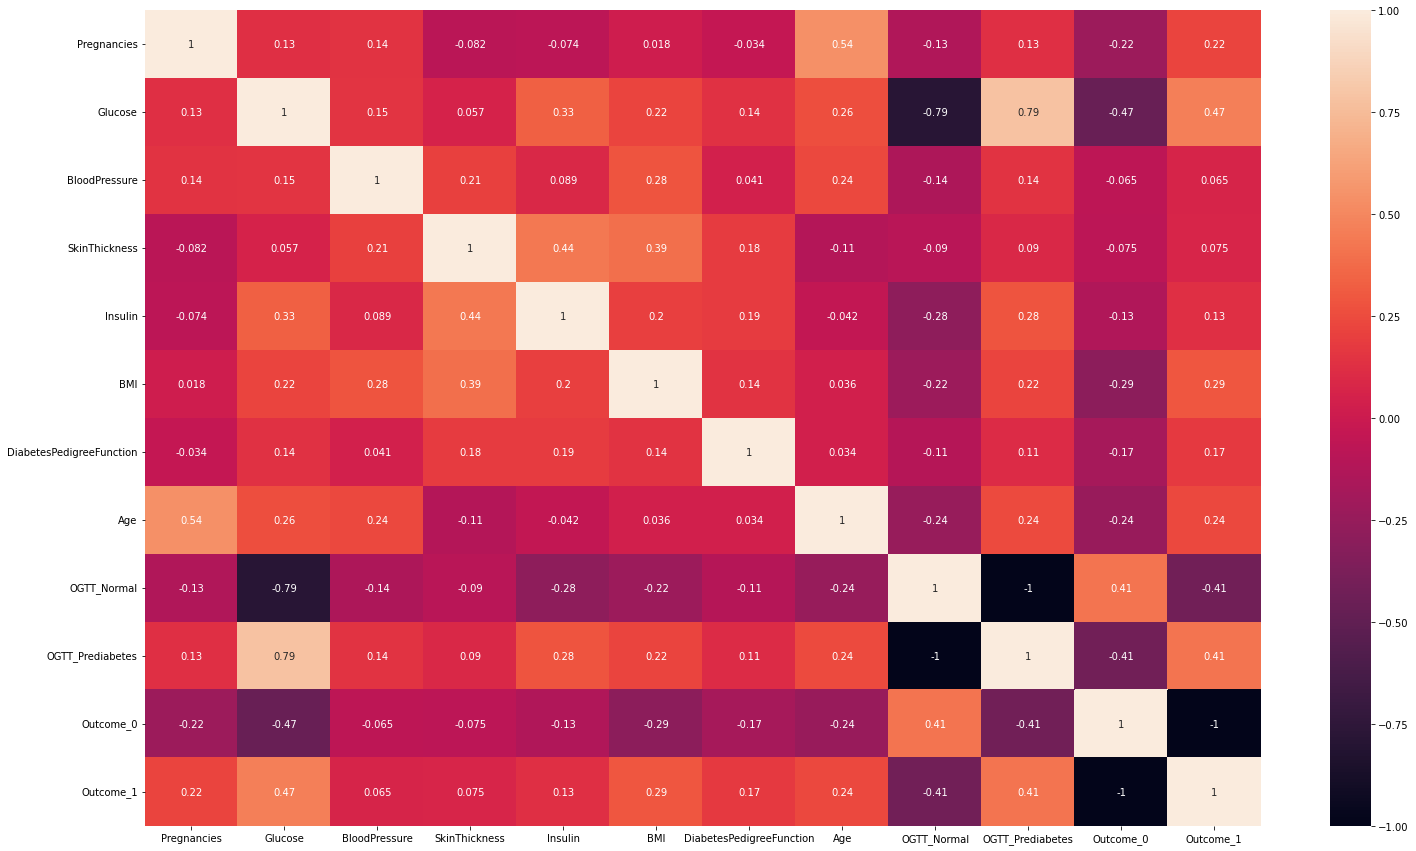

In [73]:
def show_correlations(df, show_chart = True):
    fig = plt.figure(figsize = (25,15))
    corr = df.corr()
    if show_chart == True:
        sns.heatmap(corr, 
                    xticklabels=corr.columns.values,
                    yticklabels=corr.columns.values,
                    annot=True)
    return corr

show_correlations(df_copy)

In [74]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat

    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]

    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

In [75]:
df_copy = df.copy()
df_copy = df_copy.iloc[:, [0,1,2,3,4,5,6,7,9,8]]
df_copy

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,OGTT,Outcome
0,6,148,72,35,0,33.6,0.627,50,Prediabetes,1
1,1,85,66,29,0,26.6,0.351,31,Normal,0
2,8,183,64,0,0,23.3,0.672,32,Prediabetes,1
3,1,89,66,23,94,28.1,0.167,21,Normal,0
4,0,137,40,35,168,43.1,2.288,33,Normal,1
...,...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,Normal,0
764,2,122,70,27,0,36.8,0.340,27,Normal,0
765,5,121,72,23,112,26.2,0.245,30,Normal,0
766,1,126,60,0,0,30.1,0.349,47,Normal,1


In [76]:
cat_cols, num_cols, cat_but_car = grab_col_names(df_copy)

Observations: 768
Variables: 10
cat_cols: 2
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [77]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [78]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [79]:
def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

In [80]:
check_outlier(df_copy, num_cols)

True

In [81]:
print(check_outlier(df_copy, "Pregnancies"))
print(check_outlier(df_copy, "Glucose"))
print(check_outlier(df_copy, "BloodPressure"))
print(check_outlier(df_copy, "SkinThickness"))
print(check_outlier(df_copy, "Insulin"))
print(check_outlier(df_copy, "BMI"))
print(check_outlier(df_copy, "Age"))
print(check_outlier(df_copy, "Outcome"))

False
False
False
False
True
False
False
False


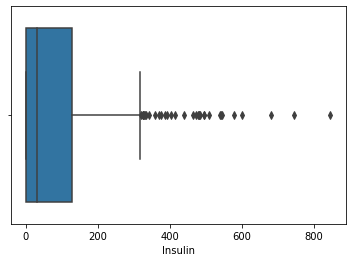

In [82]:
sns.boxplot(x=df_copy["Insulin"])
plt.show()

Ağaç temelli yöntemler kullanılacağı için outlierlara dokunulmadı.

In [83]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [84]:
df_copy = one_hot_encoder(df_copy, cat_cols, drop_first=True)

In [85]:
df_copy

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,OGTT_Prediabetes,Outcome_1
0,6,148,72,35,0,33.6,0.627,50,1,1
1,1,85,66,29,0,26.6,0.351,31,0,0
2,8,183,64,0,0,23.3,0.672,32,1,1
3,1,89,66,23,94,28.1,0.167,21,0,0
4,0,137,40,35,168,43.1,2.288,33,0,1
...,...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0,0
764,2,122,70,27,0,36.8,0.340,27,0,0
765,5,121,72,23,112,26.2,0.245,30,0,0
766,1,126,60,0,0,30.1,0.349,47,0,1


In [86]:
# The distribution of the actual values and the predictions made by the algorithms is intended to be shown not only with numerical error metrics, but also with visual graphics:

def predVisualization(test_pred, y_test):
  x_ax = range(len(test_pred))
  figure(figsize=(30, 10), dpi=80)
  plt.scatter(x_ax, y_test, lw=6, color="blue", label="original")
  plt.scatter(x_ax, test_pred, lw=4, color="red", label="predicted_rtc")
  plt.legend()
  plt.style.use('default')
  plt.show()

In [87]:
######################## Without Outliers ########################
# Tüm parametreler
X = df_copy.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8]].values
y = df_copy.iloc[:, 9].values

In [89]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = scaler.fit_transform(X)

In [90]:
# Splitting dataset:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [91]:
def LogRes(X_train, y_train, X_test, y_test):
  lr = LogisticRegression()
  model = lr.fit(X_train, y_train)
  train_preds = lr.predict(X_train)
  test_preds = lr.predict(X_test)

  #Metrics
  accuracy_score_train = accuracy_score(y_train, train_preds, normalize=False)
  accuracy_score_test = accuracy_score(y_test, test_preds, normalize=False)
  print("accuracy_score_train: ", accuracy_score_train)
  print("accuracy_score_test: ", accuracy_score_test)

  f1_score_train = f1_score(y_train, train_preds, average='binary')
  f1_score_test = f1_score(y_test, test_preds, average='binary')
  print("f1_score_train: ", f1_score_train)
  print("f1_score_test: ", f1_score_test)

  roc_auc_score_train = roc_auc_score(y_train, train_preds)
  roc_auc_score_test = roc_auc_score(y_test, test_preds)
  print("roc_auc_score_train: ", roc_auc_score_train)
  print("roc_auc_score_test: ", roc_auc_score_test)

  precision_score_train = precision_score(y_train, train_preds, average='binary')
  precision_score_test = precision_score(y_test, test_preds, average='binary')
  print("precision_score_train: ", precision_score_train)
  print("precision_score_test: ", precision_score_test)

  recall_score_train = recall_score(y_train, train_preds, average='binary')
  recall_score_test = recall_score(y_test, test_preds, average='binary')
  print("recall_score_train: ", recall_score_train)
  print("recall_score_test: ", recall_score_test)

  confusion_matrix_train = confusion_matrix(y_train, train_preds)
  confusion_matrix_test = confusion_matrix(y_test, test_preds)
  print("confusion_matrix_train: ", confusion_matrix_train)
  print("confusion_matrix_test: ", confusion_matrix_test)

  predVisualization(test_preds, y_test)

  return accuracy_score_train, accuracy_score_test, f1_score_train, f1_score_test, roc_auc_score_train, roc_auc_score_test, precision_score_train, precision_score_test, recall_score_train, recall_score_test, 

accuracy_score_train:  419
accuracy_score_test:  171
f1_score_train:  0.650887573964497
f1_score_test:  0.625
roc_auc_score_train:  0.7352466012314821
roc_auc_score_test:  0.7131622516556292
precision_score_train:  0.7333333333333333
precision_score_test:  0.625
recall_score_train:  0.5851063829787234
recall_score_test:  0.625
confusion_matrix_train:  [[309  40]
 [ 78 110]]
confusion_matrix_test:  [[121  30]
 [ 30  50]]


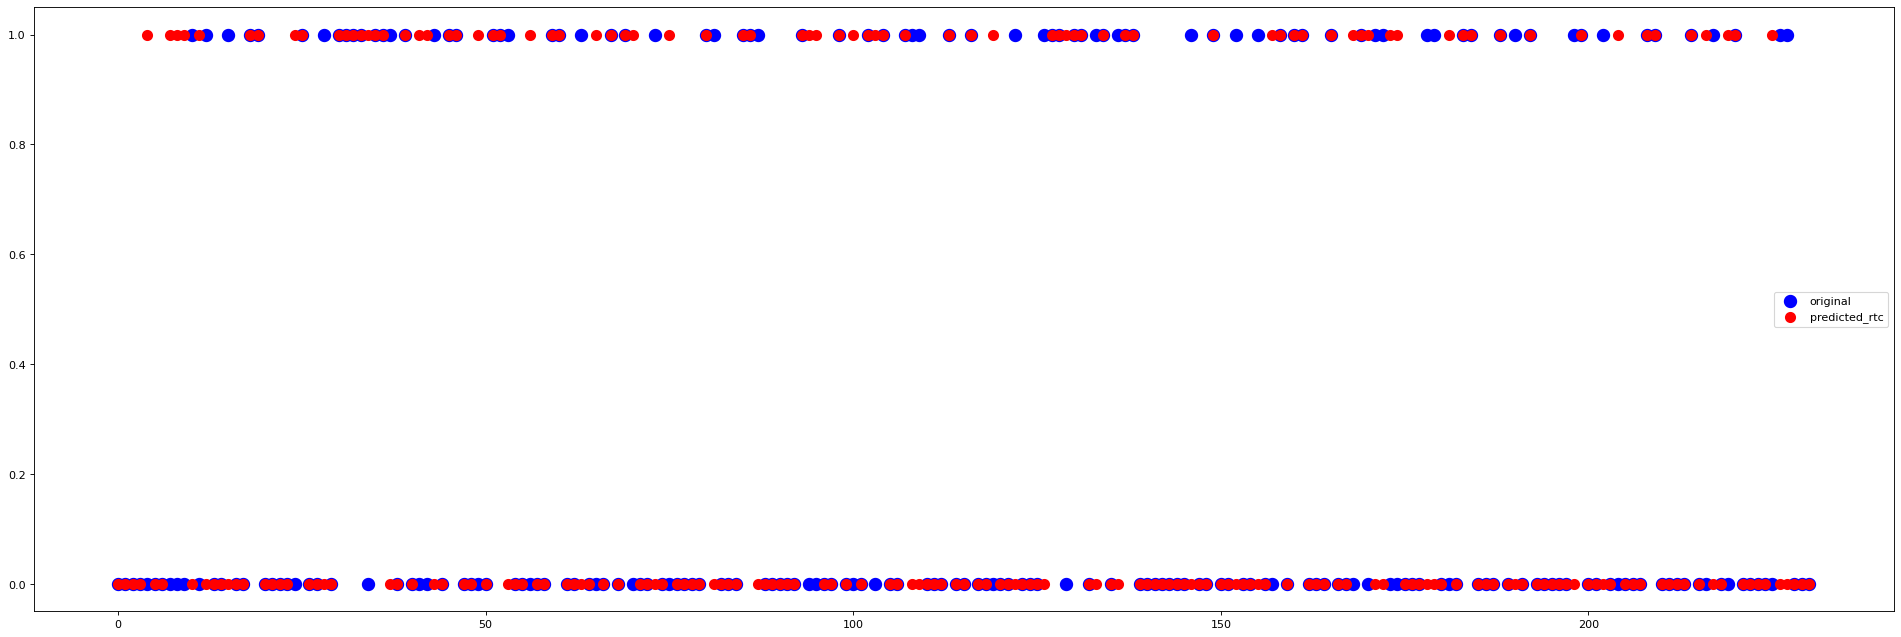

In [93]:
accuracy_score_train_lr, accuracy_score_test_lr, f1_score_train_lr, f1_score_test_lr, roc_auc_score_train_lr, roc_auc_score_test_lr, precision_score_train_lr, precision_score_test_lr, recall_score_train_lr, recall_score_test_lr,  = LogRes(X_train, y_train, X_test, y_test)

In [101]:
from sklearn.model_selection import GridSearchCV

parameters_xgb = {
        'n_estimators': [50,100,200,300,500],
        'subsample': [0, 0.5, 1], 
        'gamma' : [0, 1, 3, 6],
        'max_depth': [3, 4, 5], 
        'learning_rate': [0.001, 0.005, 0.1, 0.05]
        }

In [103]:
def XGB(X_train, y_train, X_test, y_test):
  xgboost = XGBClassifier(objective='reg:squarederror')
  xgboost_cv = GridSearchCV(xgboost, parameters_xgb, cv = 4, verbose = 3)
  xgboost_cv.fit(X_train, y_train)
  best = xgboost_cv.best_params_
  best_values = best.values()
  best_values_list = list(best_values)
  xgboost = XGBClassifier(gamma = best_values_list[0],
                         learning_rate = best_values_list[1],
                         max_depth = best_values_list[2],
                         n_estimators = best_values_list[3],
                         subsample = best_values_list[4])
  xgb_tuned =  xgboost.fit(X_train, y_train)  

  train_preds = xgb_tuned.predict(X_train)
  test_preds = xgb_tuned.predict(X_test)

  #Metrics
  accuracy_score_train = accuracy_score(y_train, train_preds, normalize=False)
  accuracy_score_test = accuracy_score(y_test, test_preds, normalize=False)
  print("accuracy_score_train: ", accuracy_score_train)
  print("accuracy_score_test: ", accuracy_score_test)

  f1_score_train = f1_score(y_train, train_preds, average='binary')
  f1_score_test = f1_score(y_test, test_preds, average='binary')
  print("f1_score_train: ", f1_score_train)
  print("f1_score_test: ", f1_score_test)

  roc_auc_score_train = roc_auc_score(y_train, train_preds)
  roc_auc_score_test = roc_auc_score(y_test, test_preds)
  print("roc_auc_score_train: ", roc_auc_score_train)
  print("roc_auc_score_test: ", roc_auc_score_test)

  precision_score_train = precision_score(y_train, train_preds, average='binary')
  precision_score_test = precision_score(y_test, test_preds, average='binary')
  print("precision_score_train: ", precision_score_train)
  print("precision_score_test: ", precision_score_test)

  recall_score_train = recall_score(y_train, train_preds, average='binary')
  recall_score_test = recall_score(y_test, test_preds, average='binary')
  print("recall_score_train: ", recall_score_train)
  print("recall_score_test: ", recall_score_test)

  confusion_matrix_train = confusion_matrix(y_train, train_preds)
  confusion_matrix_test = confusion_matrix(y_test, test_preds)
  print("confusion_matrix_train: ", confusion_matrix_train)
  print("confusion_matrix_test: ", confusion_matrix_test)

  predVisualization(test_preds, y_test)

  return accuracy_score_train, accuracy_score_test, f1_score_train, f1_score_test, roc_auc_score_train, roc_auc_score_test, precision_score_train, precision_score_test, recall_score_train, recall_score_test, 

In [ ]:
XGB(X_train, y_train, X_test, y_test)

Fitting 4 folds for each of 720 candidates, totalling 2880 fits
[CV] gamma=0, learning_rate=0.001, max_depth=3, n_estimators=50, subsample=0 
[CV]  gamma=0, learning_rate=0.001, max_depth=3, n_estimators=50, subsample=0, score=0.652, total=   0.0s
[CV] gamma=0, learning_rate=0.001, max_depth=3, n_estimators=50, subsample=0 
[CV]  gamma=0, learning_rate=0.001, max_depth=3, n_estimators=50, subsample=0, score=0.649, total=   0.0s
[CV] gamma=0, learning_rate=0.001, max_depth=3, n_estimators=50, subsample=0 
[CV]  gamma=0, learning_rate=0.001, max_depth=3, n_estimators=50, subsample=0, score=0.649, total=   0.0s
[CV] gamma=0, learning_rate=0.001, max_depth=3, n_estimators=50, subsample=0 
[CV]  gamma=0, learning_rate=0.001, max_depth=3, n_estimators=50, subsample=0, score=0.649, total=   0.0s
[CV] gamma=0, learning_rate=0.001, max_depth=3, n_estimators=50, subsample=0.5 
[CV]  gamma=0, learning_rate=0.001, max_depth=3, n_estimators=50, subsample=0.5, score=0.815, total=   0.0s
[CV] gamma=0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  gamma=0, learning_rate=0.001, max_depth=3, n_estimators=50, subsample=1, score=0.701, total=   0.0s
[CV] gamma=0, learning_rate=0.001, max_depth=3, n_estimators=50, subsample=1 
[CV]  gamma=0, learning_rate=0.001, max_depth=3, n_estimators=50, subsample=1, score=0.716, total=   0.0s
[CV] gamma=0, learning_rate=0.001, max_depth=3, n_estimators=50, subsample=1 
[CV]  gamma=0, learning_rate=0.001, max_depth=3, n_estimators=50, subsample=1, score=0.746, total=   0.0s
[CV] gamma=0, learning_rate=0.001, max_depth=3, n_estimators=100, subsample=0 
[CV]  gamma=0, learning_rate=0.001, max_depth=3, n_estimators=100, subsample=0, score=0.652, total=   0.0s
[CV] gamma=0, learning_rate=0.001, max_depth=3, n_estimators=100, subsample=0 
[CV]  gamma=0, learning_rate=0.001, max_depth=3, n_estimators=100, subsample=0, score=0.649, total=   0.0s
[CV] gamma=0, learning_rate=0.001, max_depth=3, n_estimators=100, subsample=0 
[CV]  gamma=0, learning_rate=0.001, max_depth=3, n_estimators=100, subsampl

accuracy_score_train:  493
accuracy_score_test:  173
f1_score_train:  0.8797814207650274
f1_score_test:  0.6588235294117647
roc_auc_score_train:  0.9038361885021032
roc_auc_score_test:  0.7374172185430463
precision_score_train:  0.9044943820224719
precision_score_test:  0.6222222222222222
recall_score_train:  0.8563829787234043
recall_score_test:  0.7
confusion_matrix_train:  [[332  17]
 [ 27 161]]
confusion_matrix_test:  [[117  34]
 [ 24  56]]


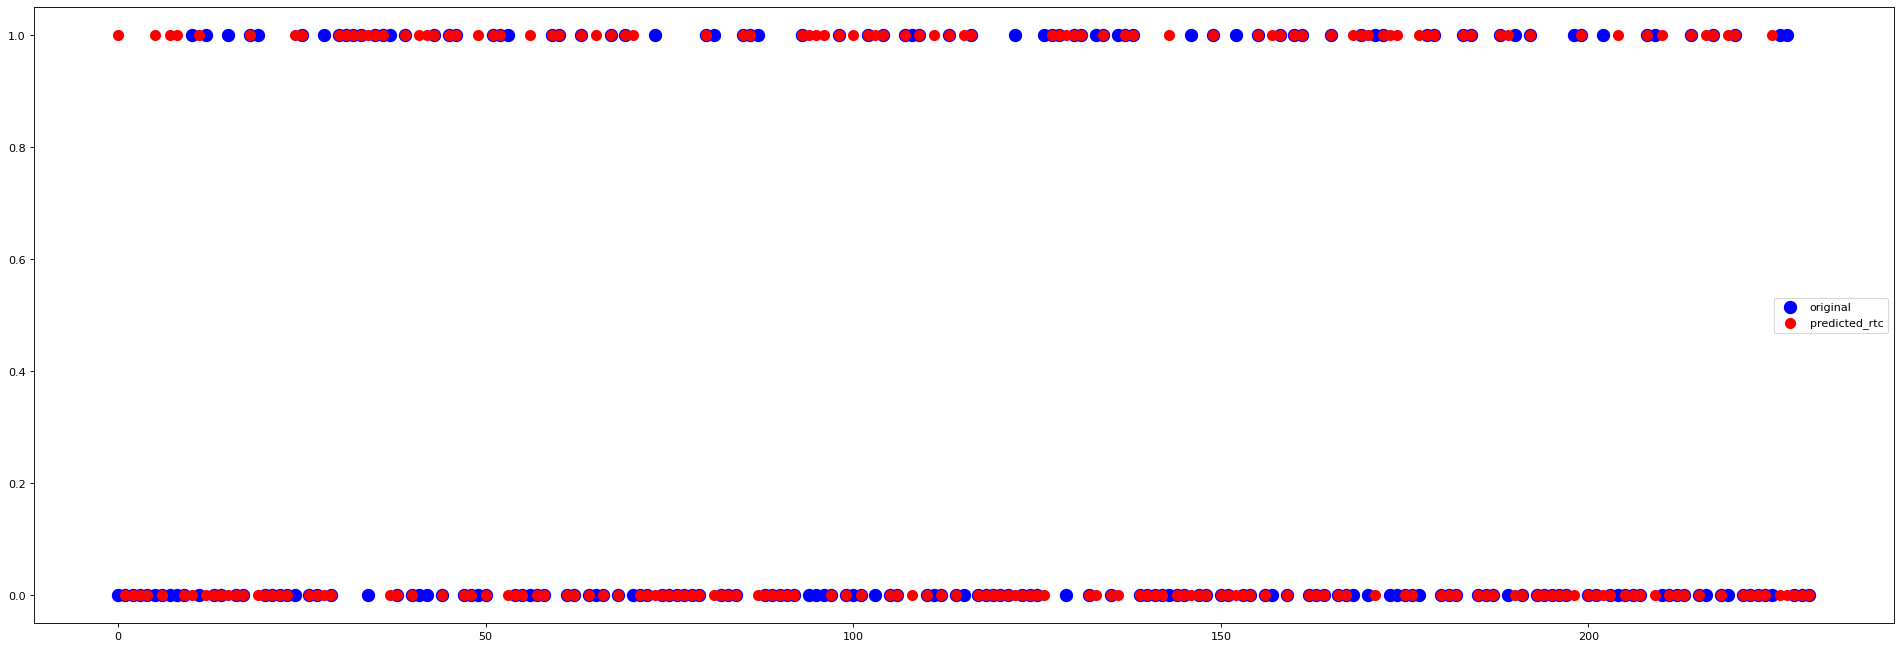

In [98]:
accuracy_score_train_xgb, accuracy_score_test_xgb, f1_score_train_xgb, f1_score_test_xgb, roc_auc_score_train_xgb, roc_auc_score_test_xgb, precision_score_train_xgb, precision_score_test_xgb, recall_score_train_xgb, recall_score_test_xgb = XGB(X_train, y_train, X_test, y_test)

In [ ]:
# XGBoost Logisctic Regression'a oranla beklenildiği gibi çok daha iyi sonuçlar vermektedir. X_4 493/173 doğru

In [ ]:
def KNN(X_train, y_train, X_test, y_test):
  knn = KNeighborsClassifier()
  model = knn.fit(X_train, y_train)
  train_preds = knn.predict(X_train)
  test_preds = knn.predict(X_test)

  #Metrics
  accuracy_score_train = accuracy_score(y_train, train_preds, normalize=False)
  accuracy_score_test = accuracy_score(y_test, test_preds, normalize=False)
  print("accuracy_score_train: ", accuracy_score_train)
  print("accuracy_score_test: ", accuracy_score_test)

  f1_score_train = f1_score(y_train, train_preds, average='binary')
  f1_score_test = f1_score(y_test, test_preds, average='binary')
  print("f1_score_train: ", f1_score_train)
  print("f1_score_test: ", f1_score_test)

  roc_auc_score_train = roc_auc_score(y_train, train_preds)
  roc_auc_score_test = roc_auc_score(y_test, test_preds)
  print("roc_auc_score_train: ", roc_auc_score_train)
  print("roc_auc_score_test: ", roc_auc_score_test)

  precision_score_train = precision_score(y_train, train_preds, average='binary')
  precision_score_test = precision_score(y_test, test_preds, average='binary')
  print("precision_score_train: ", precision_score_train)
  print("precision_score_test: ", precision_score_test)

  recall_score_train = recall_score(y_train, train_preds, average='binary')
  recall_score_test = recall_score(y_test, test_preds, average='binary')
  print("recall_score_train: ", recall_score_train)
  print("recall_score_test: ", recall_score_test)

  confusion_matrix_train = confusion_matrix(y_train, train_preds)
  confusion_matrix_test = confusion_matrix(y_test, test_preds)
  print("confusion_matrix_train: ", confusion_matrix_train)
  print("confusion_matrix_test: ", confusion_matrix_test)

  predVisualization(test_preds, y_test)

accuracy_score_train:  399
accuracy_score_test:  158
f1_score_train:  0.6878980891719746
f1_score_test:  0.5599999999999999
roc_auc_score_train:  0.7608092238710366
roc_auc_score_test:  0.686189177852349
precision_score_train:  0.7714285714285715
precision_score_test:  0.5737704918032787
recall_score_train:  0.6206896551724138
recall_score_test:  0.546875
confusion_matrix_train:  [[291  32]
 [ 66 108]]
confusion_matrix_test:  [[123  26]
 [ 29  35]]


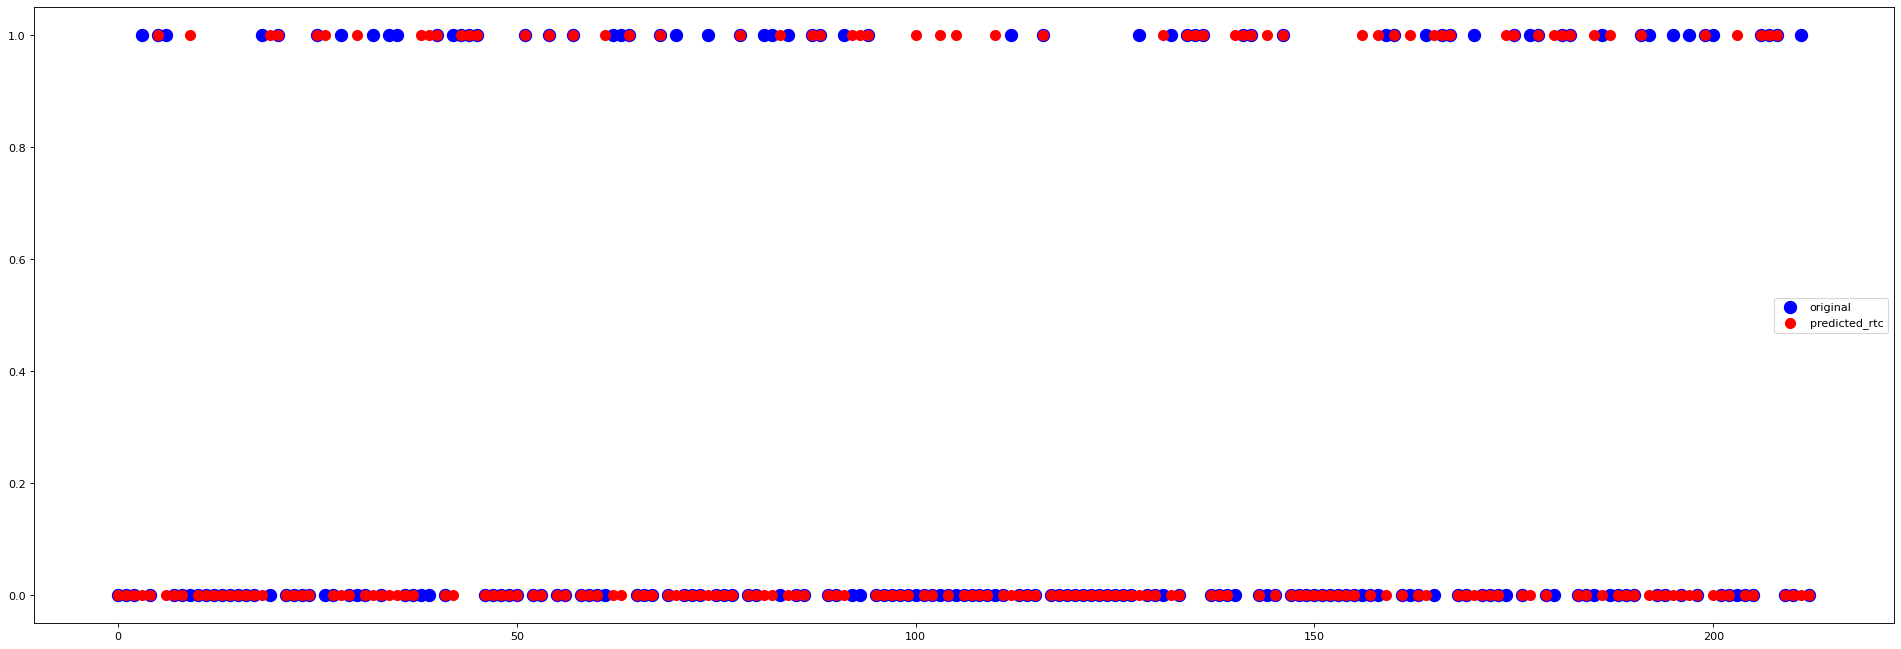

accuracy_score_train:  400
accuracy_score_test:  158
f1_score_train:  0.6996904024767802
f1_score_test:  0.5864661654135338
roc_auc_score_train:  0.7689850894985943
roc_auc_score_test:  0.7040163590604027
precision_score_train:  0.7583892617449665
precision_score_test:  0.5652173913043478
recall_score_train:  0.6494252873563219
recall_score_test:  0.609375
confusion_matrix_train:  [[287  36]
 [ 61 113]]
confusion_matrix_test:  [[119  30]
 [ 25  39]]


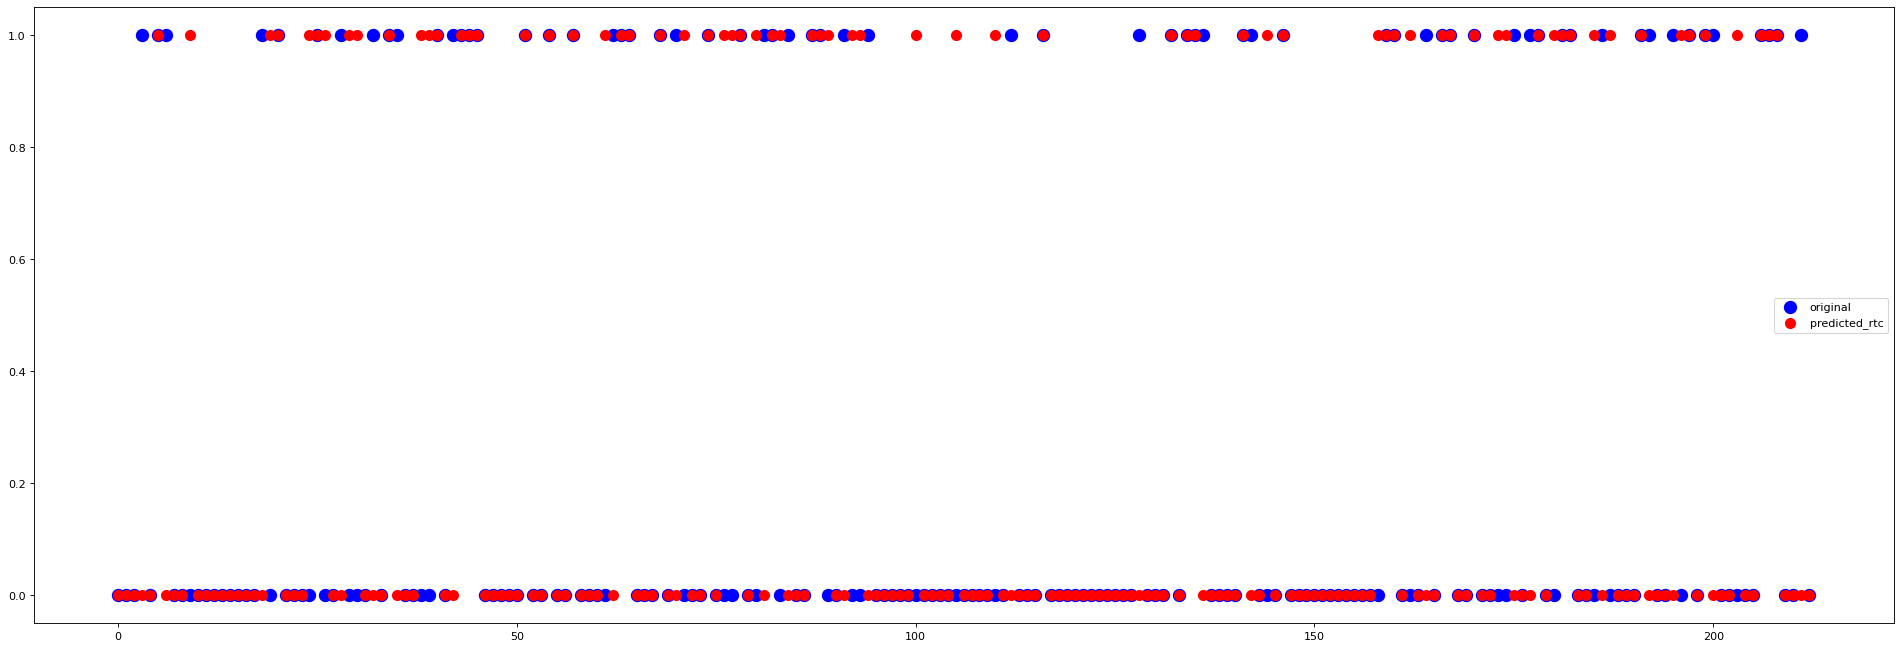

accuracy_score_train:  400
accuracy_score_test:  157
f1_score_train:  0.7051671732522796
f1_score_test:  0.5555555555555557
roc_auc_score_train:  0.7729618163054695
roc_auc_score_test:  0.6828334731543625
precision_score_train:  0.7483870967741936
precision_score_test:  0.5645161290322581
recall_score_train:  0.6666666666666666
recall_score_test:  0.546875
confusion_matrix_train:  [[284  39]
 [ 58 116]]
confusion_matrix_test:  [[122  27]
 [ 29  35]]


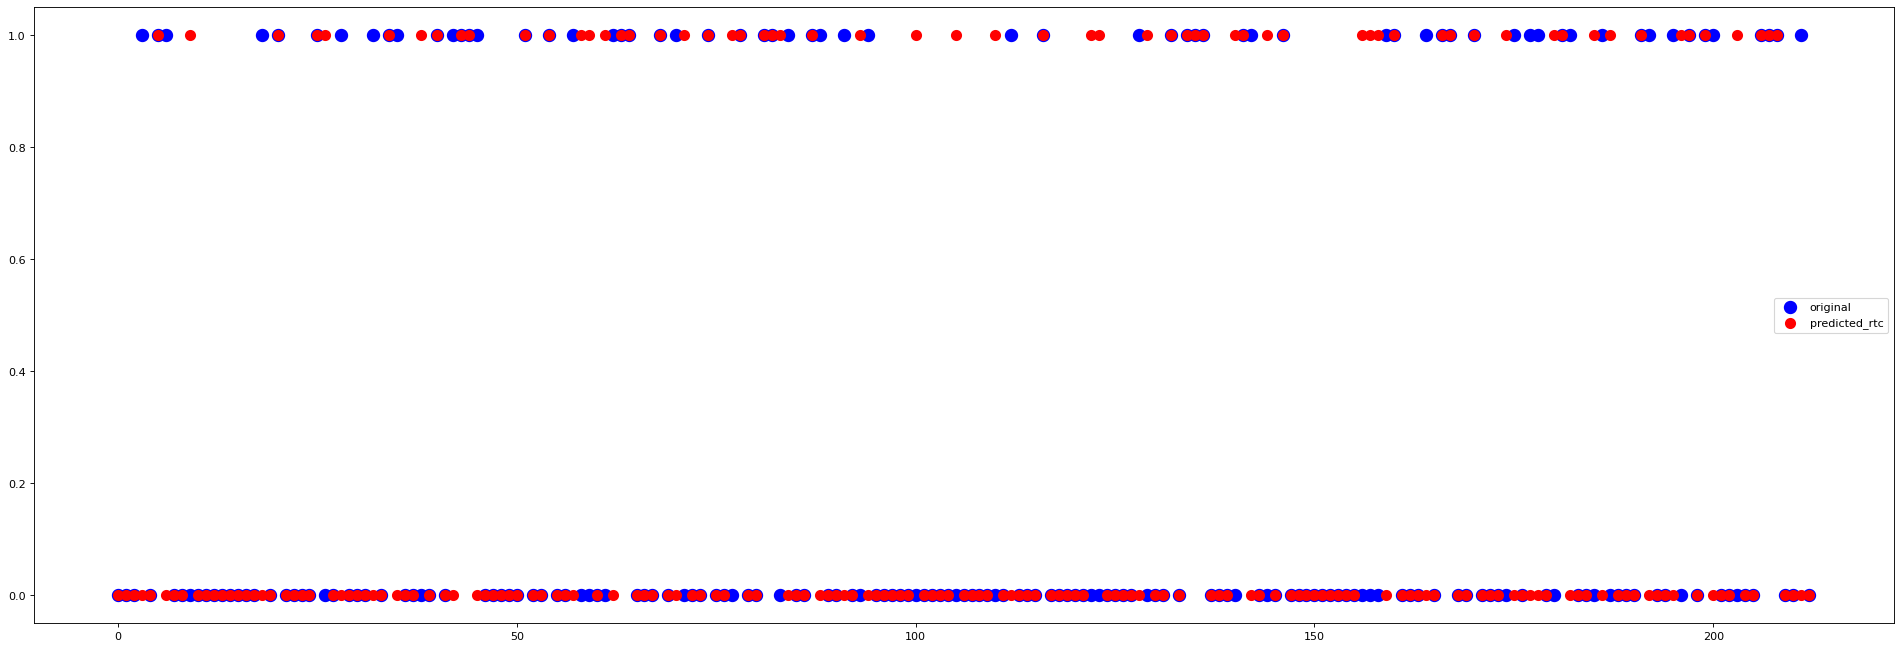

accuracy_score_train:  431
accuracy_score_test:  159
f1_score_train:  0.6954022988505747
f1_score_test:  0.5555555555555556
roc_auc_score_train:  0.7659345851368652
roc_auc_score_test:  0.6587334437086093
precision_score_train:  0.75625
precision_score_test:  0.5487804878048781
recall_score_train:  0.6436170212765957
recall_score_test:  0.5625
confusion_matrix_train:  [[310  39]
 [ 67 121]]
confusion_matrix_test:  [[114  37]
 [ 35  45]]


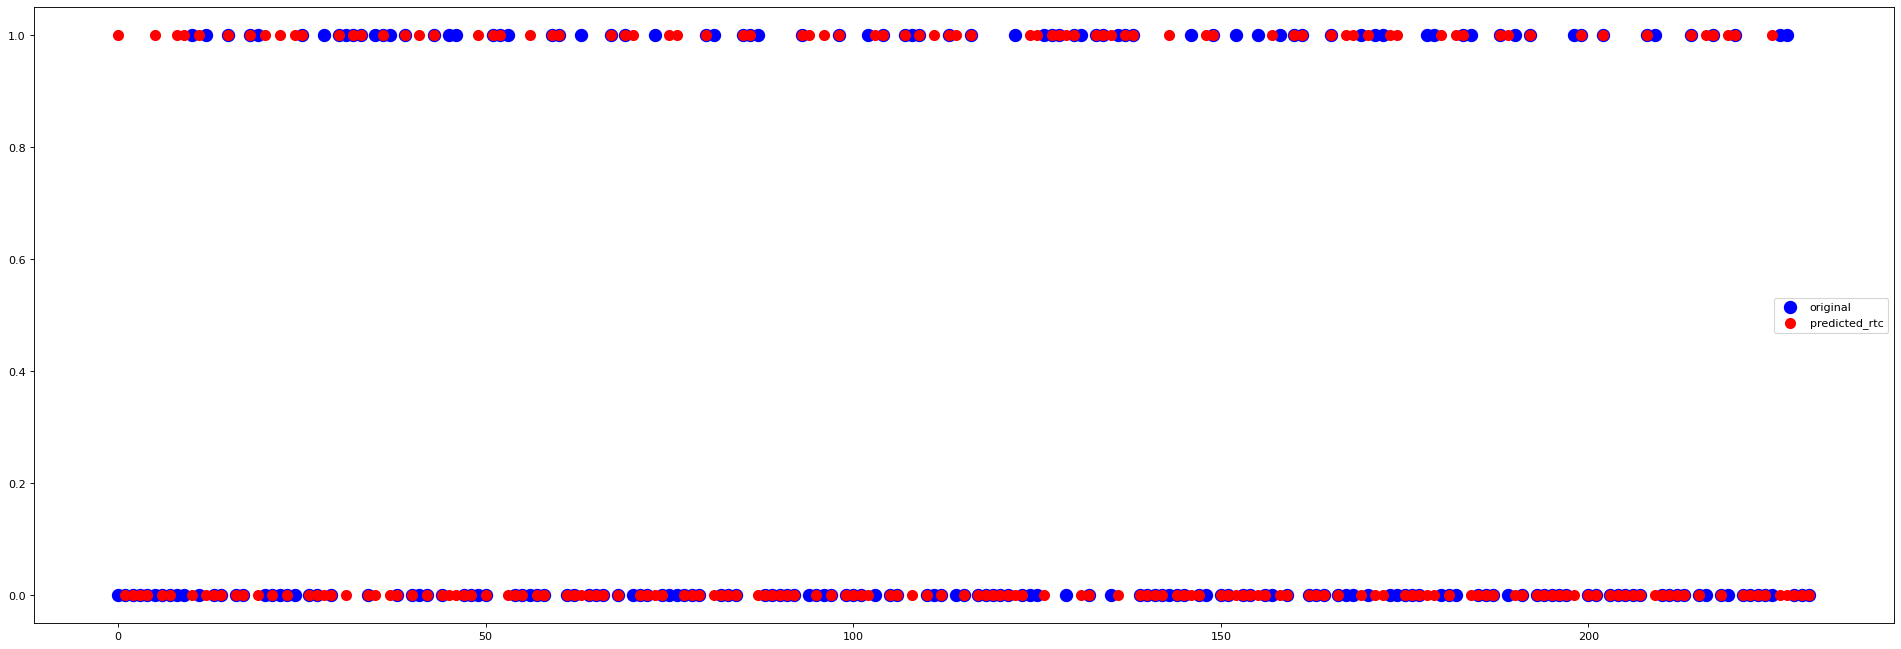

accuracy_score_train:  433
accuracy_score_test:  148
f1_score_train:  0.7142857142857143
f1_score_test:  0.49696969696969695
roc_auc_score_train:  0.7798421020545023
roc_auc_score_test:  0.6105546357615894
precision_score_train:  0.7386363636363636
precision_score_test:  0.4823529411764706
recall_score_train:  0.6914893617021277
recall_score_test:  0.5125
confusion_matrix_train:  [[303  46]
 [ 58 130]]
confusion_matrix_test:  [[107  44]
 [ 39  41]]


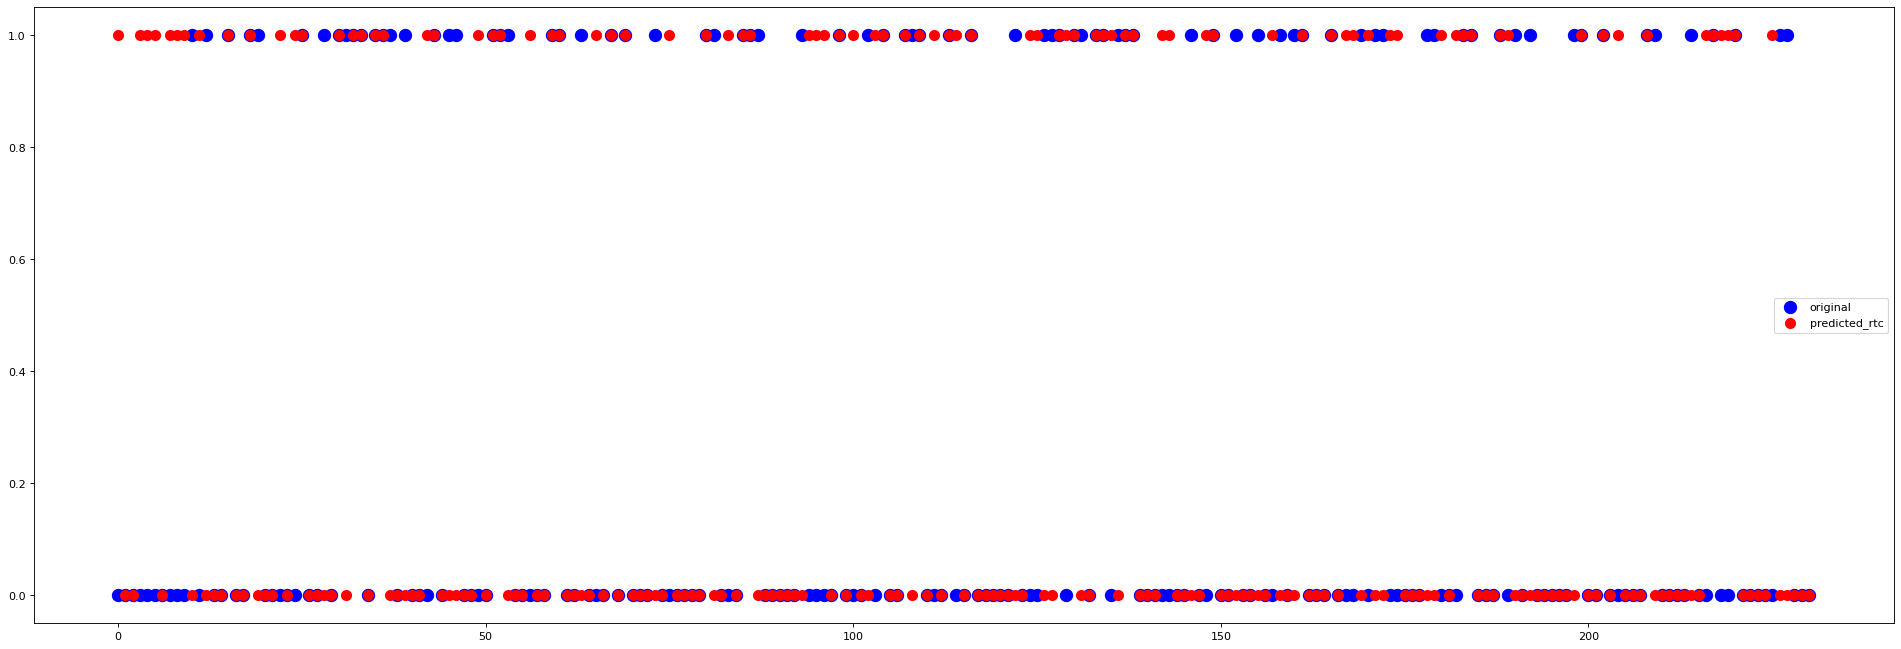

accuracy_score_train:  438
accuracy_score_test:  155
f1_score_train:  0.7211267605633803
f1_score_test:  0.525
roc_auc_score_train:  0.784551606413461
roc_auc_score_test:  0.6366721854304636
precision_score_train:  0.7664670658682635
precision_score_test:  0.525
recall_score_train:  0.6808510638297872
recall_score_test:  0.525
confusion_matrix_train:  [[310  39]
 [ 60 128]]
confusion_matrix_test:  [[113  38]
 [ 38  42]]


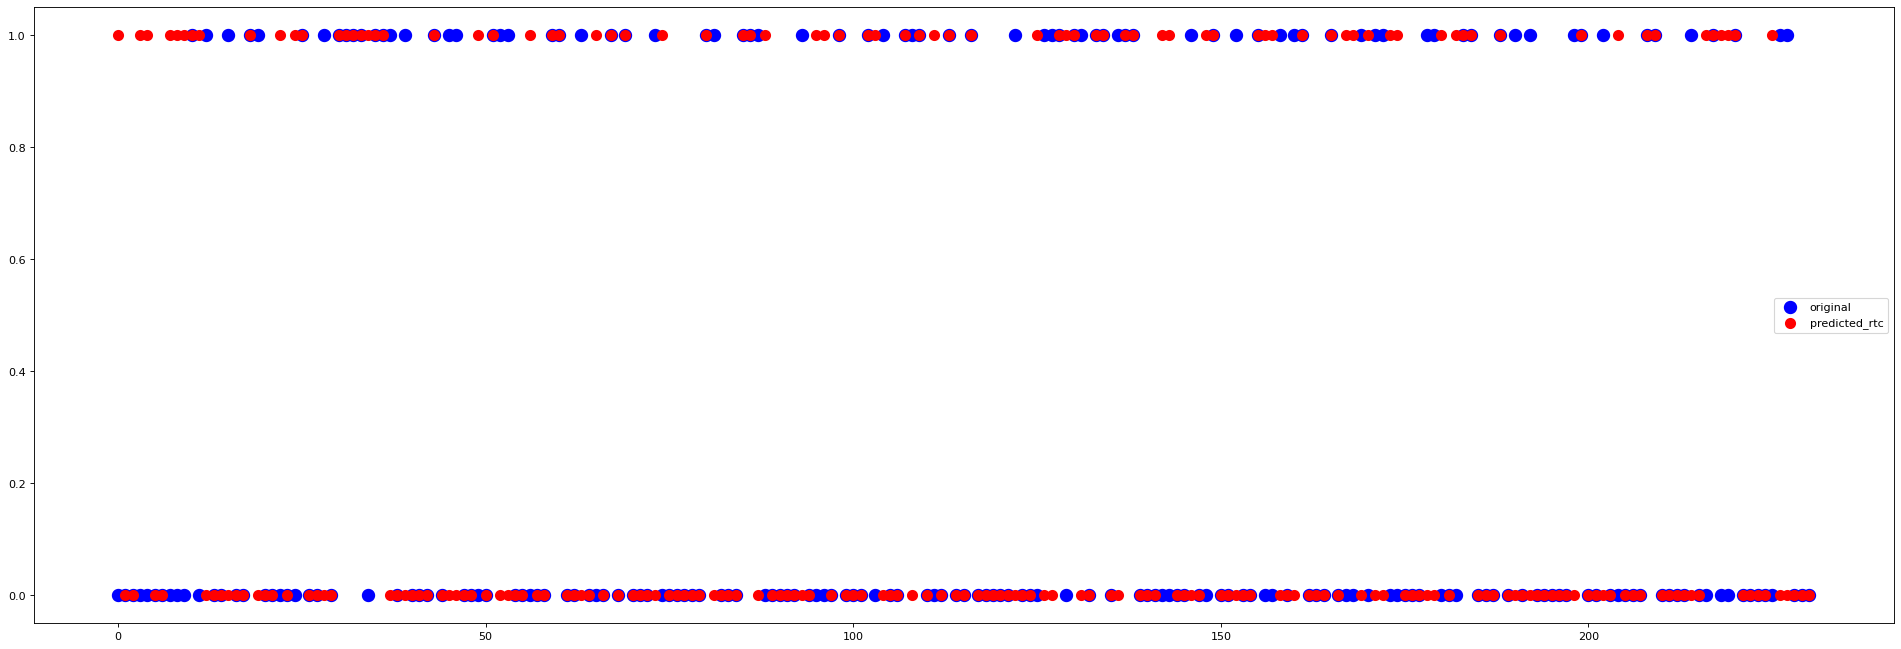

In [ ]:
KNN(X_train_1, y_train_1, X_test_1, y_test_1)
KNN(X_train_2, y_train_2, X_test_2, y_test_2)
KNN(X_train_3, y_train_3, X_test_3, y_test_3)
KNN(X_train_4, y_train_4, X_test_4, y_test_4)
KNN(X_train_5, y_train_5, X_test_5, y_test_5)
KNN(X_train_6, y_train_6, X_test_6, y_test_6)

In [ ]:
# KNN XGBoosta göre daha az doğru sonuç verdi. X_6 438/155 doğru.

In [ ]:
def RFC(X_train, y_train, X_test, y_test):
  rfc = RandomForestClassifier(n_estimators=30)
  model = rfc.fit(X_train, y_train)
  train_preds = rfc.predict(X_train)
  test_preds = rfc.predict(X_test)

  #Metrics
  accuracy_score_train = accuracy_score(y_train, train_preds, normalize=False)
  accuracy_score_test = accuracy_score(y_test, test_preds, normalize=False)
  print("accuracy_score_train: ", accuracy_score_train)
  print("accuracy_score_test: ", accuracy_score_test)

  f1_score_train = f1_score(y_train, train_preds, average='binary')
  f1_score_test = f1_score(y_test, test_preds, average='binary')
  print("f1_score_train: ", f1_score_train)
  print("f1_score_test: ", f1_score_test)

  roc_auc_score_train = roc_auc_score(y_train, train_preds)
  roc_auc_score_test = roc_auc_score(y_test, test_preds)
  print("roc_auc_score_train: ", roc_auc_score_train)
  print("roc_auc_score_test: ", roc_auc_score_test)

  precision_score_train = precision_score(y_train, train_preds, average='binary')
  precision_score_test = precision_score(y_test, test_preds, average='binary')
  print("precision_score_train: ", precision_score_train)
  print("precision_score_test: ", precision_score_test)

  recall_score_train = recall_score(y_train, train_preds, average='binary')
  recall_score_test = recall_score(y_test, test_preds, average='binary')
  print("recall_score_train: ", recall_score_train)
  print("recall_score_test: ", recall_score_test)

  confusion_matrix_train = confusion_matrix(y_train, train_preds)
  confusion_matrix_test = confusion_matrix(y_test, test_preds)
  print("confusion_matrix_train: ", confusion_matrix_train)
  print("confusion_matrix_test: ", confusion_matrix_test)

  predVisualization(test_preds, y_test)

accuracy_score_train:  496
accuracy_score_test:  171
f1_score_train:  0.9971181556195965
f1_score_test:  0.65
roc_auc_score_train:  0.9971264367816092
roc_auc_score_test:  0.7476405201342282
precision_score_train:  1.0
precision_score_test:  0.6964285714285714
recall_score_train:  0.9942528735632183
recall_score_test:  0.609375
confusion_matrix_train:  [[323   0]
 [  1 173]]
confusion_matrix_test:  [[132  17]
 [ 25  39]]


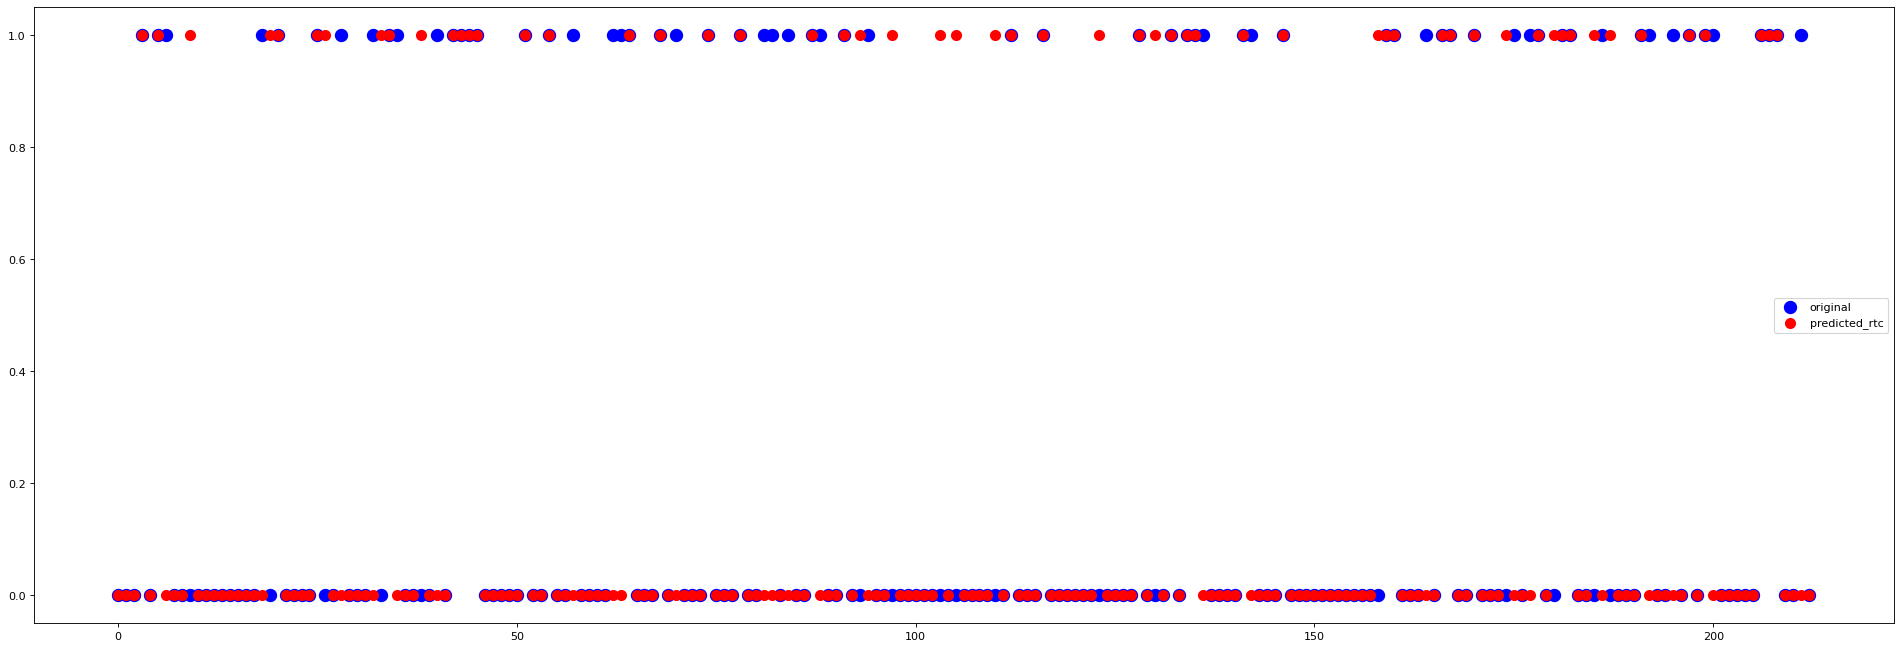

accuracy_score_train:  495
accuracy_score_test:  172
f1_score_train:  0.9942196531791908
f1_score_test:  0.6611570247933884
roc_auc_score_train:  0.9942528735632183
roc_auc_score_test:  0.7554530201342282
precision_score_train:  1.0
precision_score_test:  0.7017543859649122
recall_score_train:  0.9885057471264368
recall_score_test:  0.625
confusion_matrix_train:  [[323   0]
 [  2 172]]
confusion_matrix_test:  [[132  17]
 [ 24  40]]


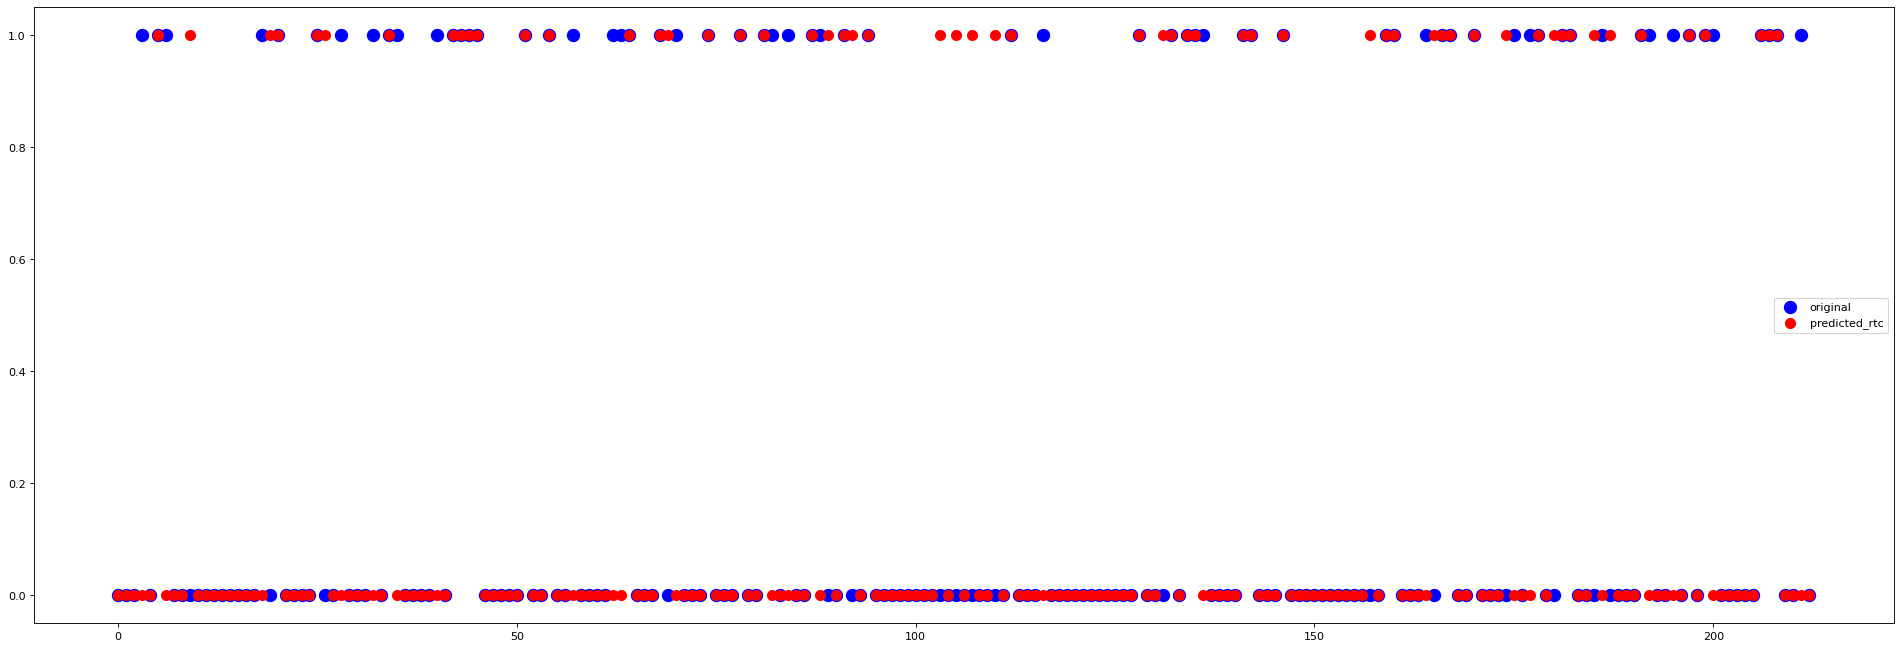

accuracy_score_train:  496
accuracy_score_test:  163
f1_score_train:  0.9971181556195965
f1_score_test:  0.5689655172413792
roc_auc_score_train:  0.9971264367816092
roc_auc_score_test:  0.694054110738255
precision_score_train:  1.0
precision_score_test:  0.6346153846153846
recall_score_train:  0.9942528735632183
recall_score_test:  0.515625
confusion_matrix_train:  [[323   0]
 [  1 173]]
confusion_matrix_test:  [[130  19]
 [ 31  33]]


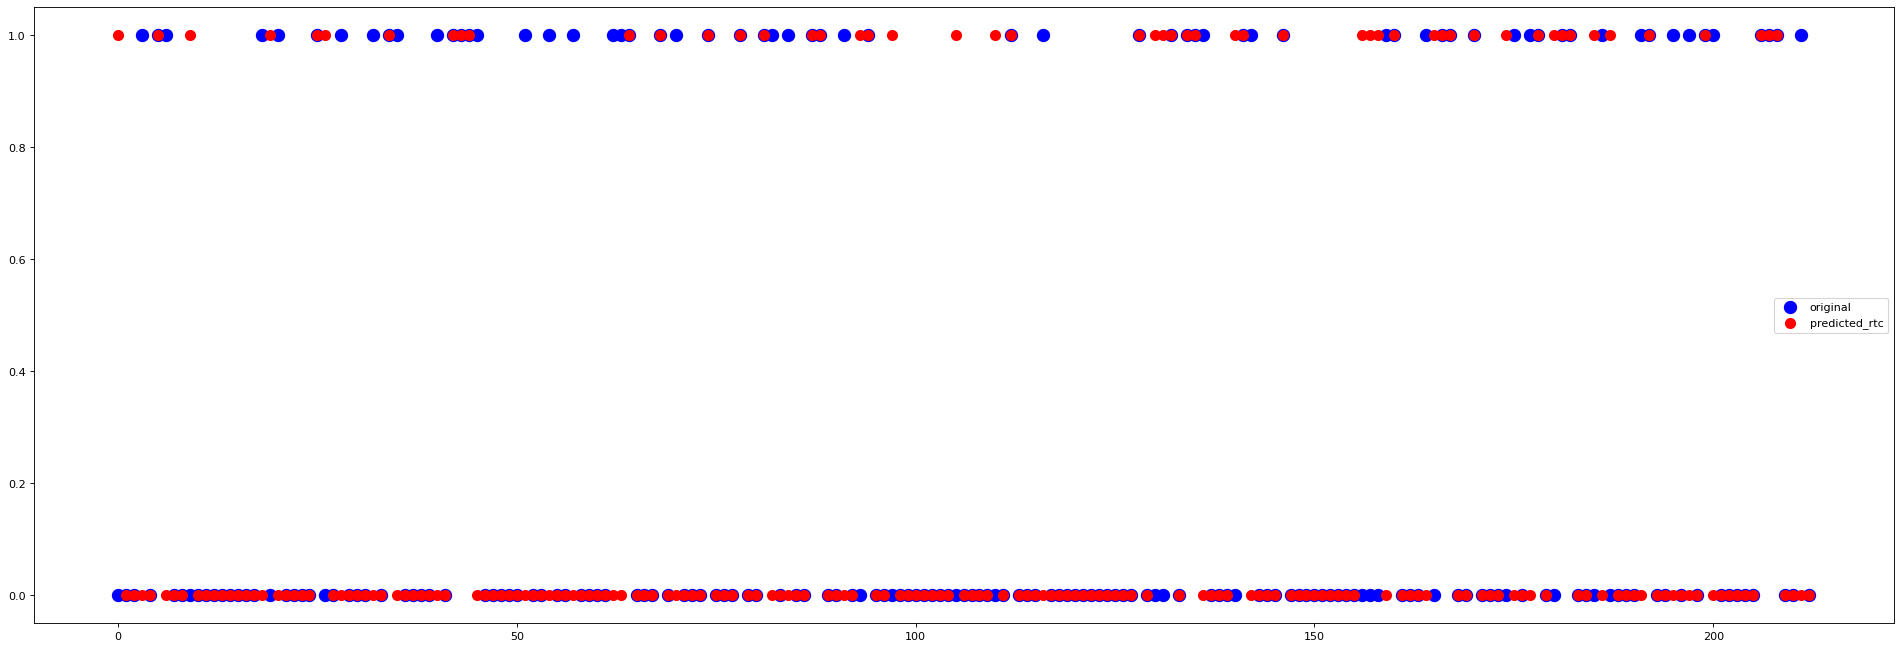

accuracy_score_train:  537
accuracy_score_test:  164
f1_score_train:  1.0
f1_score_test:  0.5620915032679739
roc_auc_score_train:  1.0
roc_auc_score_test:  0.6694122516556292
precision_score_train:  1.0
precision_score_test:  0.589041095890411
recall_score_train:  1.0
recall_score_test:  0.5375
confusion_matrix_train:  [[349   0]
 [  0 188]]
confusion_matrix_test:  [[121  30]
 [ 37  43]]


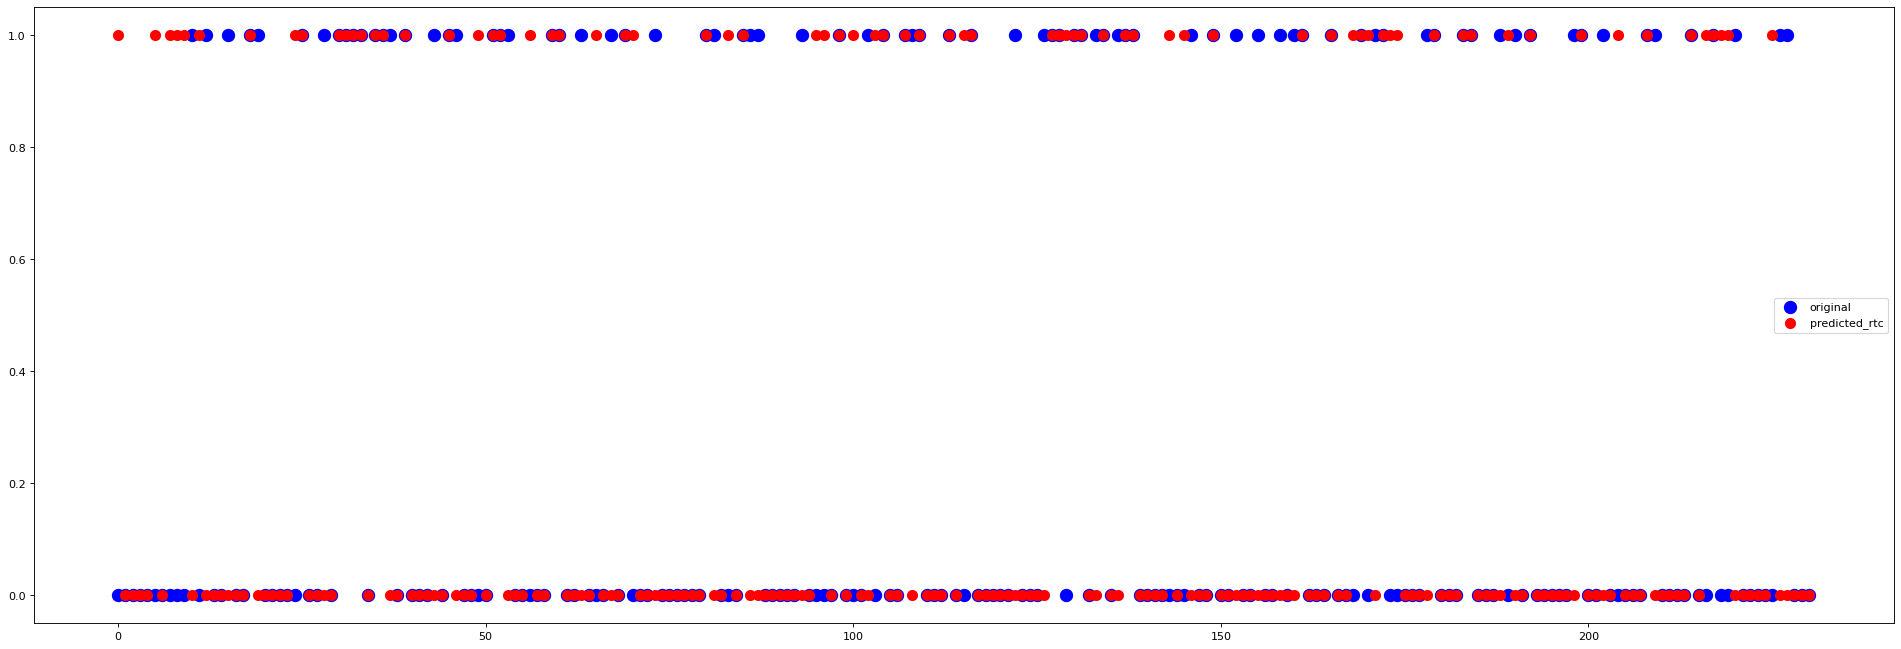

accuracy_score_train:  537
accuracy_score_test:  171
f1_score_train:  1.0
f1_score_test:  0.625
roc_auc_score_train:  1.0
roc_auc_score_test:  0.7131622516556292
precision_score_train:  1.0
precision_score_test:  0.625
recall_score_train:  1.0
recall_score_test:  0.625
confusion_matrix_train:  [[349   0]
 [  0 188]]
confusion_matrix_test:  [[121  30]
 [ 30  50]]


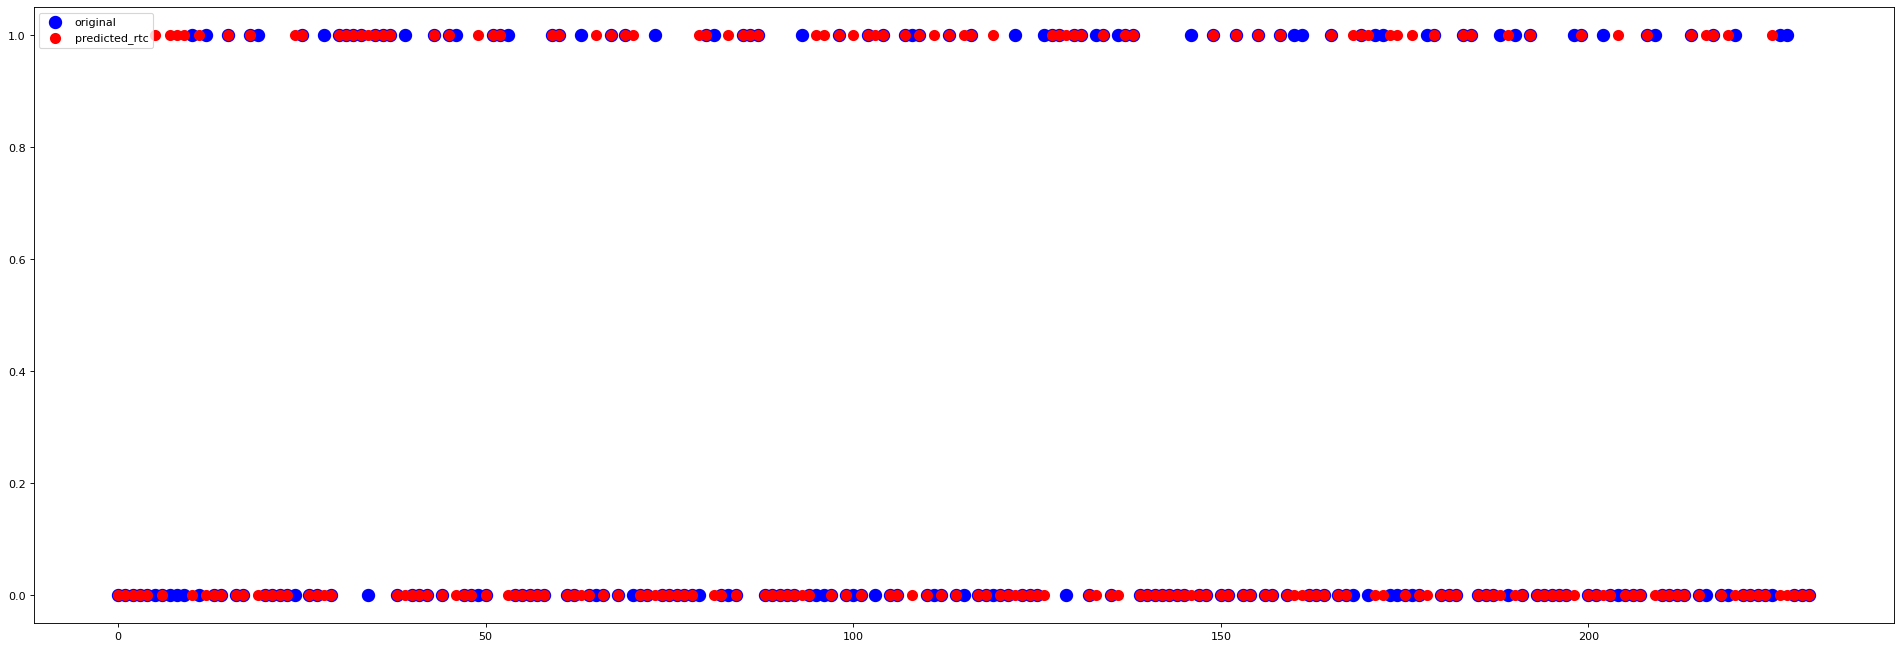

accuracy_score_train:  536
accuracy_score_test:  168
f1_score_train:  0.9973333333333333
f1_score_test:  0.6272189349112426
roc_auc_score_train:  0.9973404255319149
roc_auc_score_test:  0.712044701986755
precision_score_train:  1.0
precision_score_test:  0.5955056179775281
recall_score_train:  0.9946808510638298
recall_score_test:  0.6625
confusion_matrix_train:  [[349   0]
 [  1 187]]
confusion_matrix_test:  [[115  36]
 [ 27  53]]


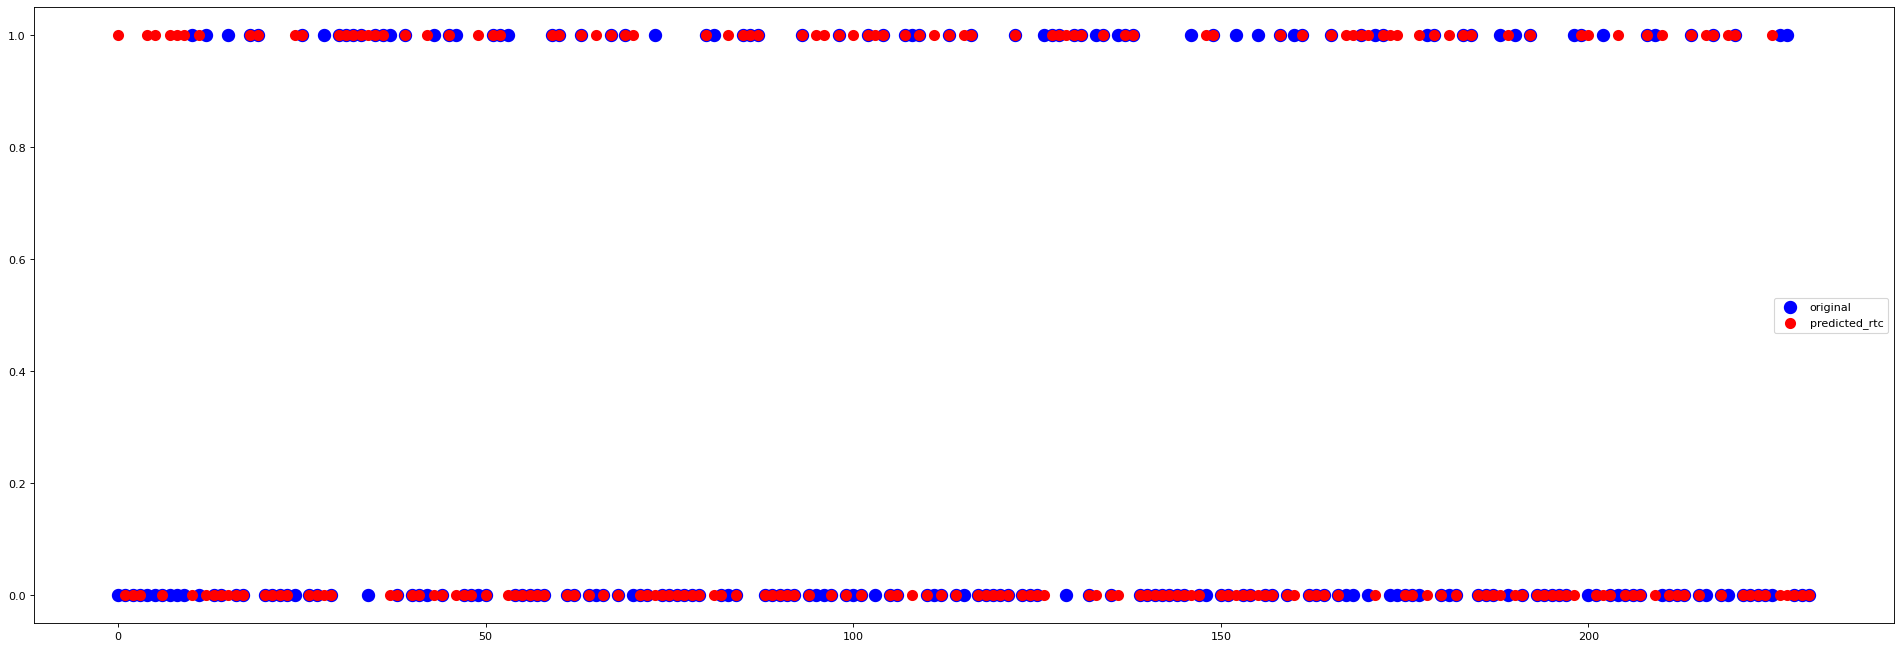

In [ ]:
RFC(X_train_1, y_train_1, X_test_1, y_test_1)
RFC(X_train_2, y_train_2, X_test_2, y_test_2)
RFC(X_train_3, y_train_3, X_test_3, y_test_3)
RFC(X_train_4, y_train_4, X_test_4, y_test_4)
RFC(X_train_5, y_train_5, X_test_5, y_test_5)
RFC(X_train_6, y_train_6, X_test_6, y_test_6)

In [ ]:
# RFC daha iyi sonuçlar verdi ancak train/testteki sonuçlar arasındaki fark overfitting olduğu anlamını taşımaktadır. Model default ayarlardan gevşetilebilir.

In [ ]:
def DTC(X_train, y_train, X_test, y_test):
  dtc = DecisionTreeClassifier()
  model = dtc.fit(X_train, y_train)
  train_preds = dtc.predict(X_train)
  test_preds = dtc.predict(X_test)

  #Metrics
  accuracy_score_train = accuracy_score(y_train, train_preds, normalize=False)
  accuracy_score_test = accuracy_score(y_test, test_preds, normalize=False)
  print("accuracy_score_train: ", accuracy_score_train)
  print("accuracy_score_test: ", accuracy_score_test)

  f1_score_train = f1_score(y_train, train_preds, average='binary')
  f1_score_test = f1_score(y_test, test_preds, average='binary')
  print("f1_score_train: ", f1_score_train)
  print("f1_score_test: ", f1_score_test)

  roc_auc_score_train = roc_auc_score(y_train, train_preds)
  roc_auc_score_test = roc_auc_score(y_test, test_preds)
  print("roc_auc_score_train: ", roc_auc_score_train)
  print("roc_auc_score_test: ", roc_auc_score_test)

  precision_score_train = precision_score(y_train, train_preds, average='binary')
  precision_score_test = precision_score(y_test, test_preds, average='binary')
  print("precision_score_train: ", precision_score_train)
  print("precision_score_test: ", precision_score_test)

  recall_score_train = recall_score(y_train, train_preds, average='binary')
  recall_score_test = recall_score(y_test, test_preds, average='binary')
  print("recall_score_train: ", recall_score_train)
  print("recall_score_test: ", recall_score_test)

  confusion_matrix_train = confusion_matrix(y_train, train_preds)
  confusion_matrix_test = confusion_matrix(y_test, test_preds)
  print("confusion_matrix_train: ", confusion_matrix_train)
  print("confusion_matrix_test: ", confusion_matrix_test)

  predVisualization(test_preds, y_test)

accuracy_score_train:  497
accuracy_score_test:  152
f1_score_train:  1.0
f1_score_test:  0.5611510791366907
roc_auc_score_train:  1.0
roc_auc_score_test:  0.6838821308724833
precision_score_train:  1.0
precision_score_test:  0.52
recall_score_train:  1.0
recall_score_test:  0.609375
confusion_matrix_train:  [[323   0]
 [  0 174]]
confusion_matrix_test:  [[113  36]
 [ 25  39]]


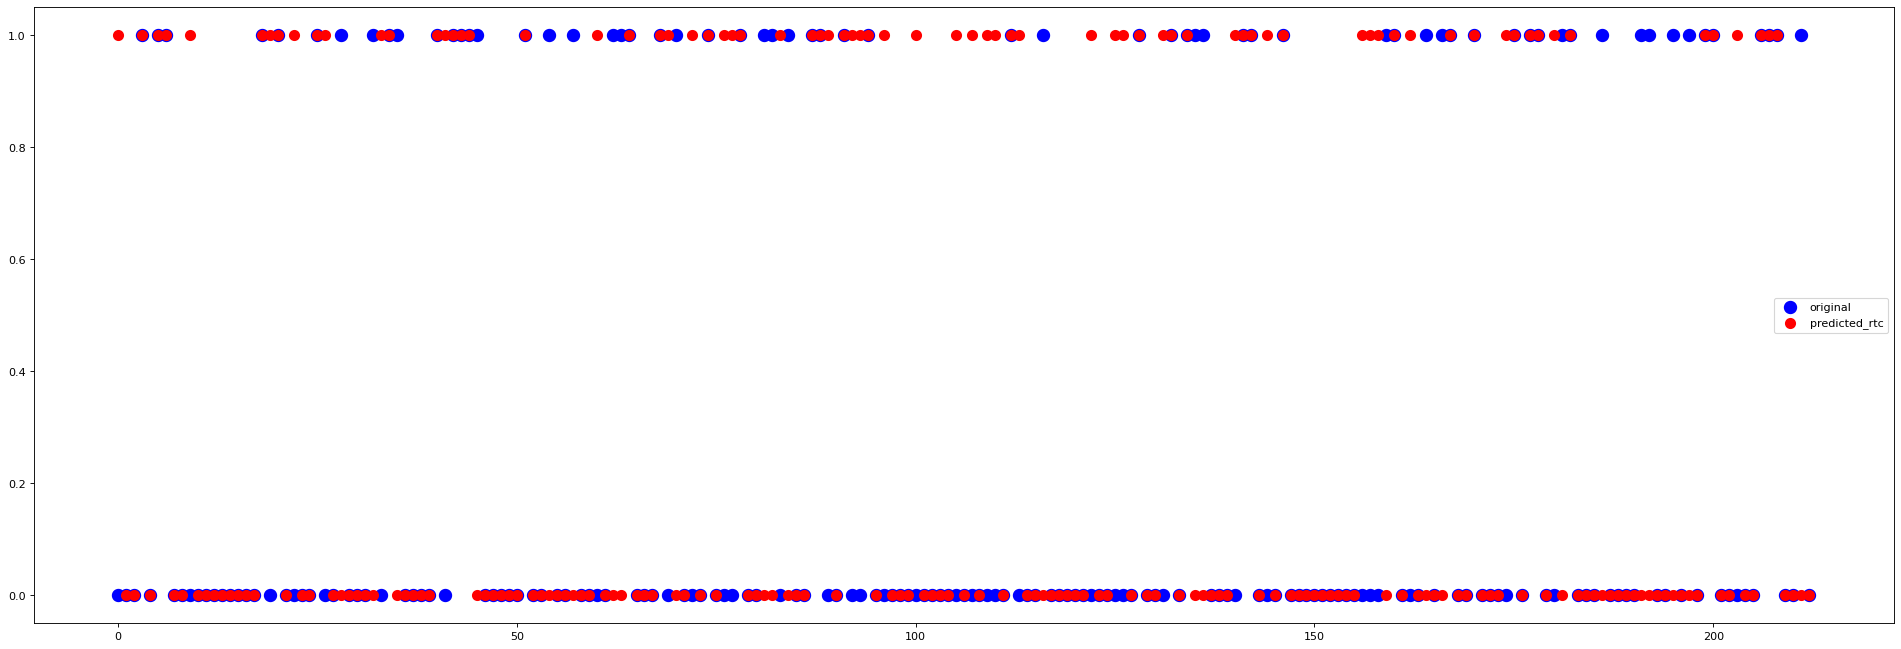

accuracy_score_train:  497
accuracy_score_test:  158
f1_score_train:  1.0
f1_score_test:  0.6153846153846154
roc_auc_score_train:  1.0
roc_auc_score_test:  0.7263003355704698
precision_score_train:  1.0
precision_score_test:  0.5569620253164557
recall_score_train:  1.0
recall_score_test:  0.6875
confusion_matrix_train:  [[323   0]
 [  0 174]]
confusion_matrix_test:  [[114  35]
 [ 20  44]]


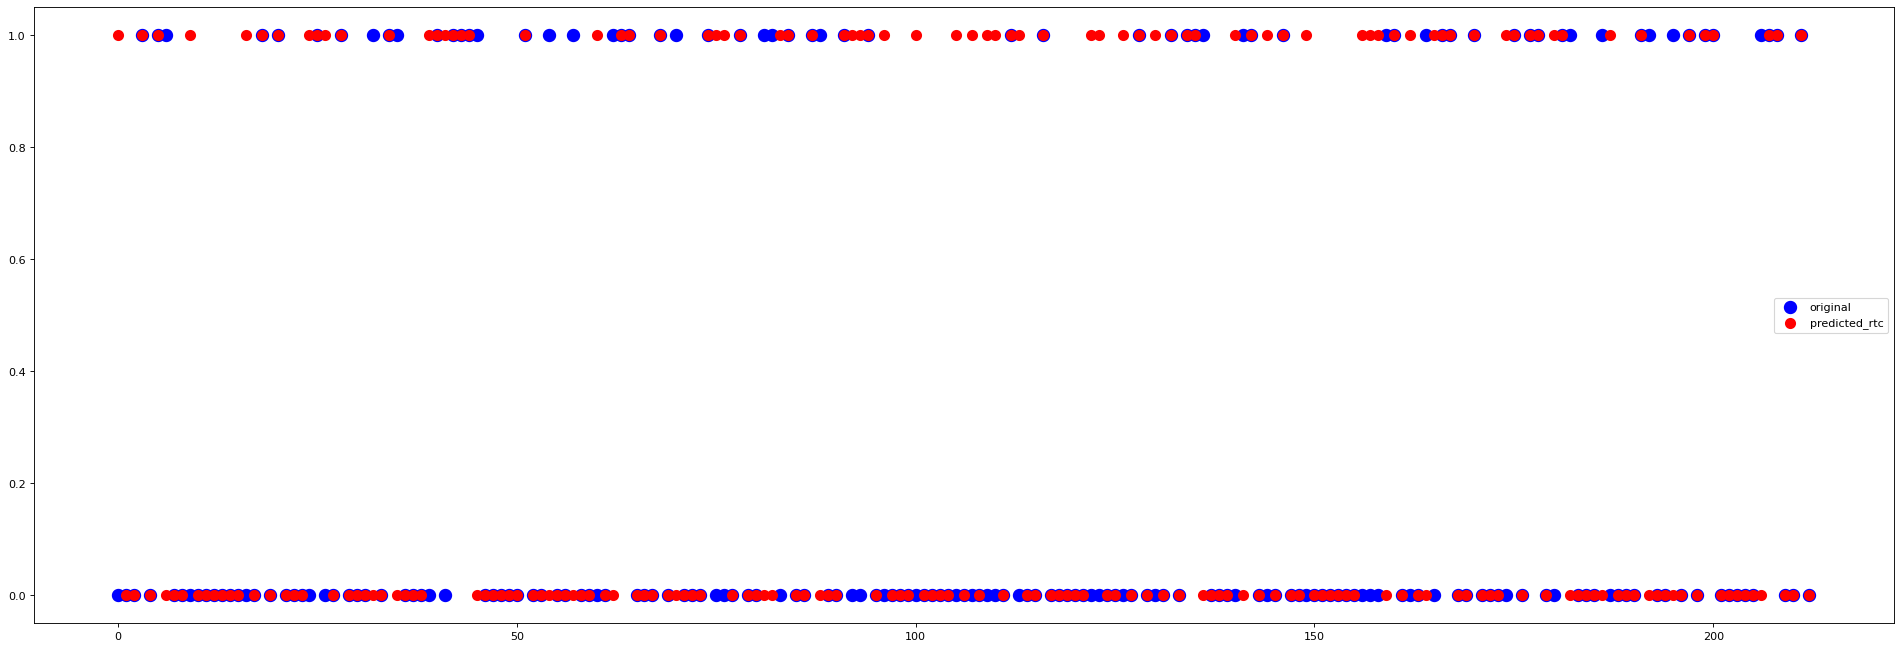

accuracy_score_train:  497
accuracy_score_test:  147
f1_score_train:  1.0
f1_score_test:  0.5147058823529411
roc_auc_score_train:  1.0
roc_auc_score_test:  0.6492764261744967
precision_score_train:  1.0
precision_score_test:  0.4861111111111111
recall_score_train:  1.0
recall_score_test:  0.546875
confusion_matrix_train:  [[323   0]
 [  0 174]]
confusion_matrix_test:  [[112  37]
 [ 29  35]]


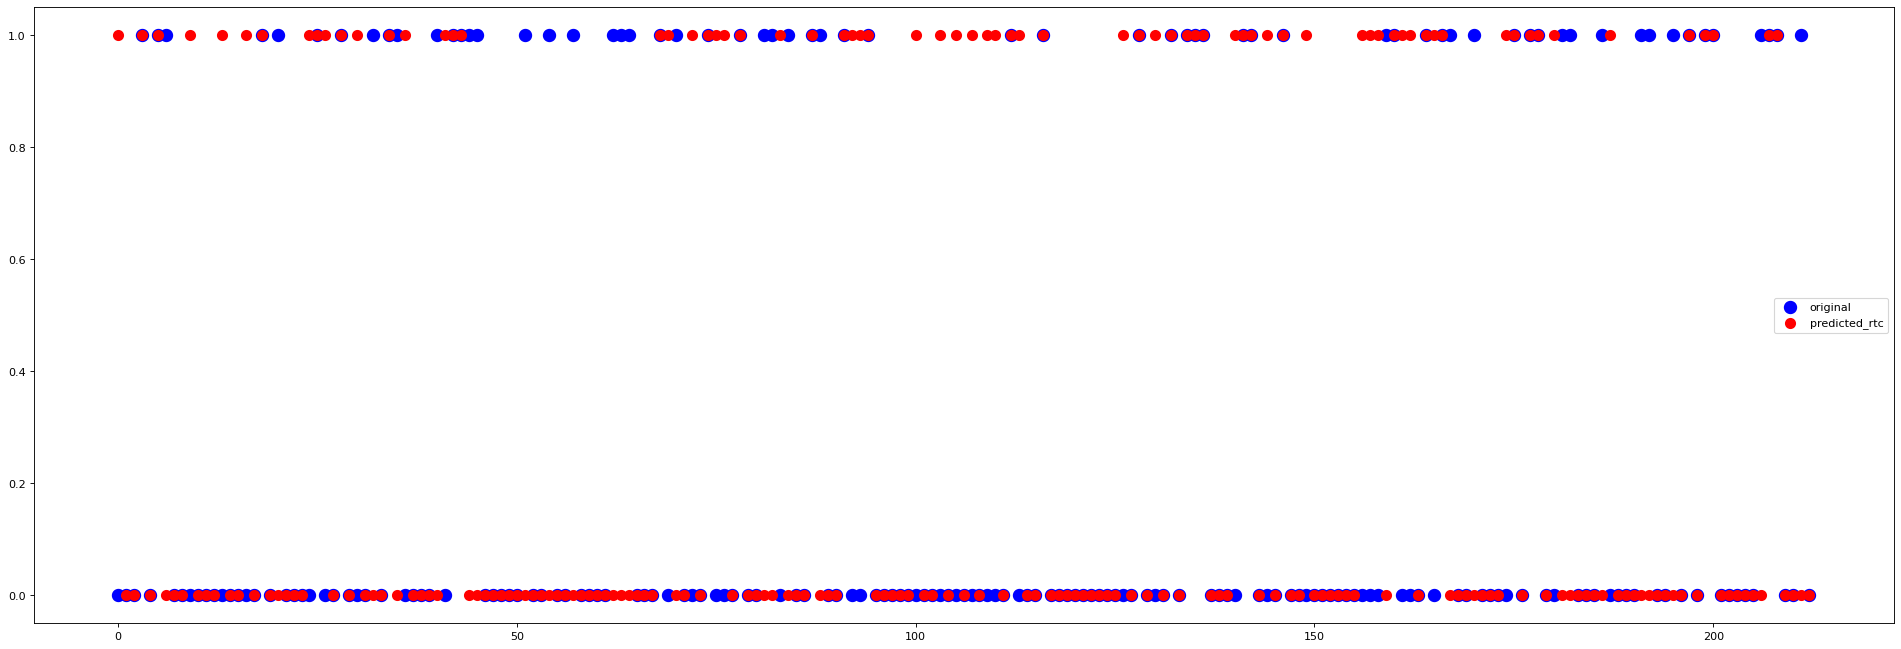

accuracy_score_train:  537
accuracy_score_test:  161
f1_score_train:  1.0
f1_score_test:  0.6022727272727273
roc_auc_score_train:  1.0
roc_auc_score_test:  0.6888658940397352
precision_score_train:  1.0
precision_score_test:  0.5520833333333334
recall_score_train:  1.0
recall_score_test:  0.6625
confusion_matrix_train:  [[349   0]
 [  0 188]]
confusion_matrix_test:  [[108  43]
 [ 27  53]]


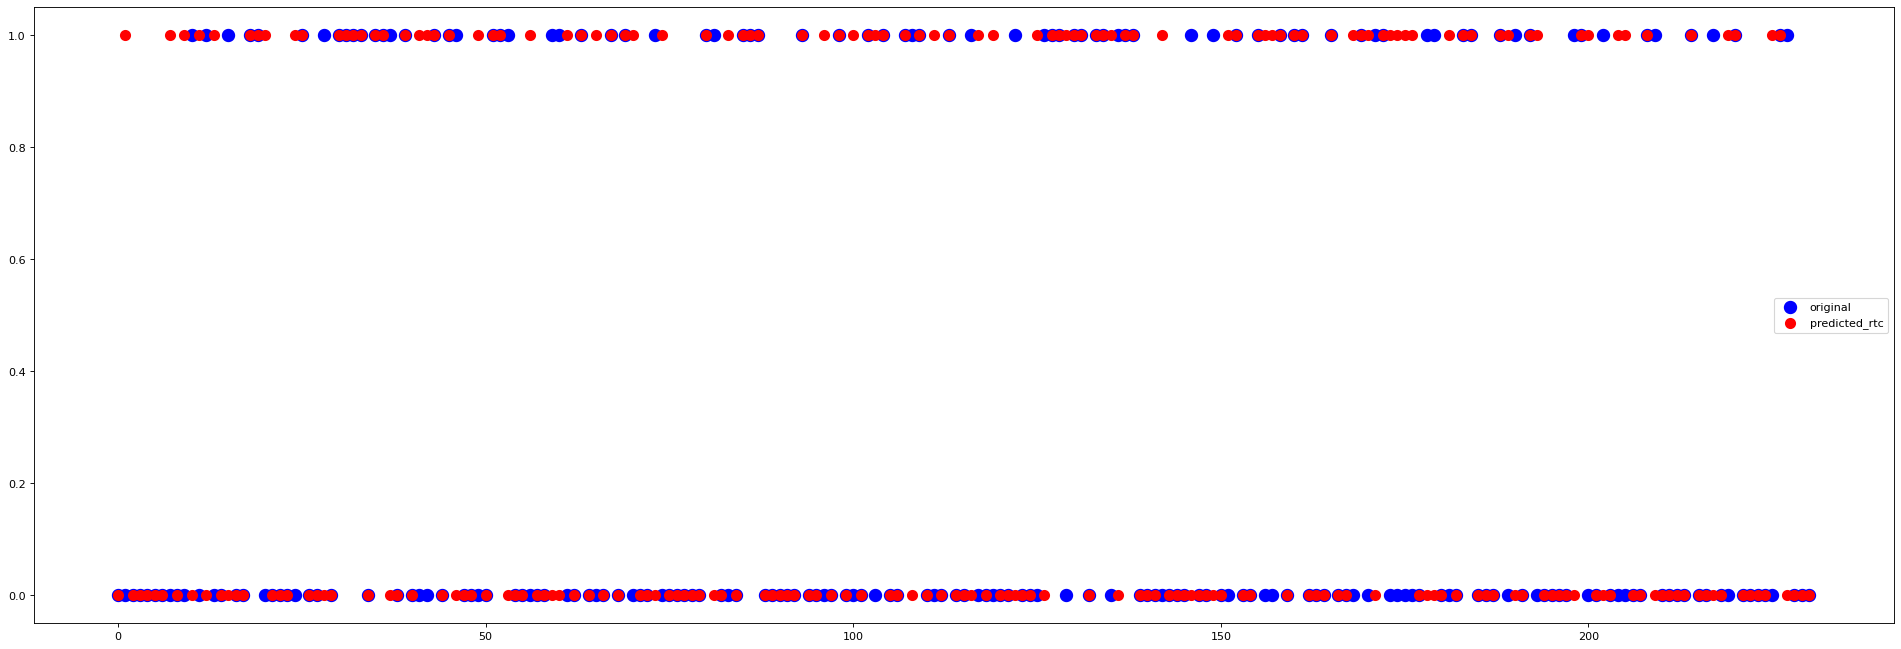

accuracy_score_train:  537
accuracy_score_test:  153
f1_score_train:  1.0
f1_score_test:  0.5517241379310344
roc_auc_score_train:  1.0
roc_auc_score_test:  0.6476821192052981
precision_score_train:  1.0
precision_score_test:  0.5106382978723404
recall_score_train:  1.0
recall_score_test:  0.6
confusion_matrix_train:  [[349   0]
 [  0 188]]
confusion_matrix_test:  [[105  46]
 [ 32  48]]


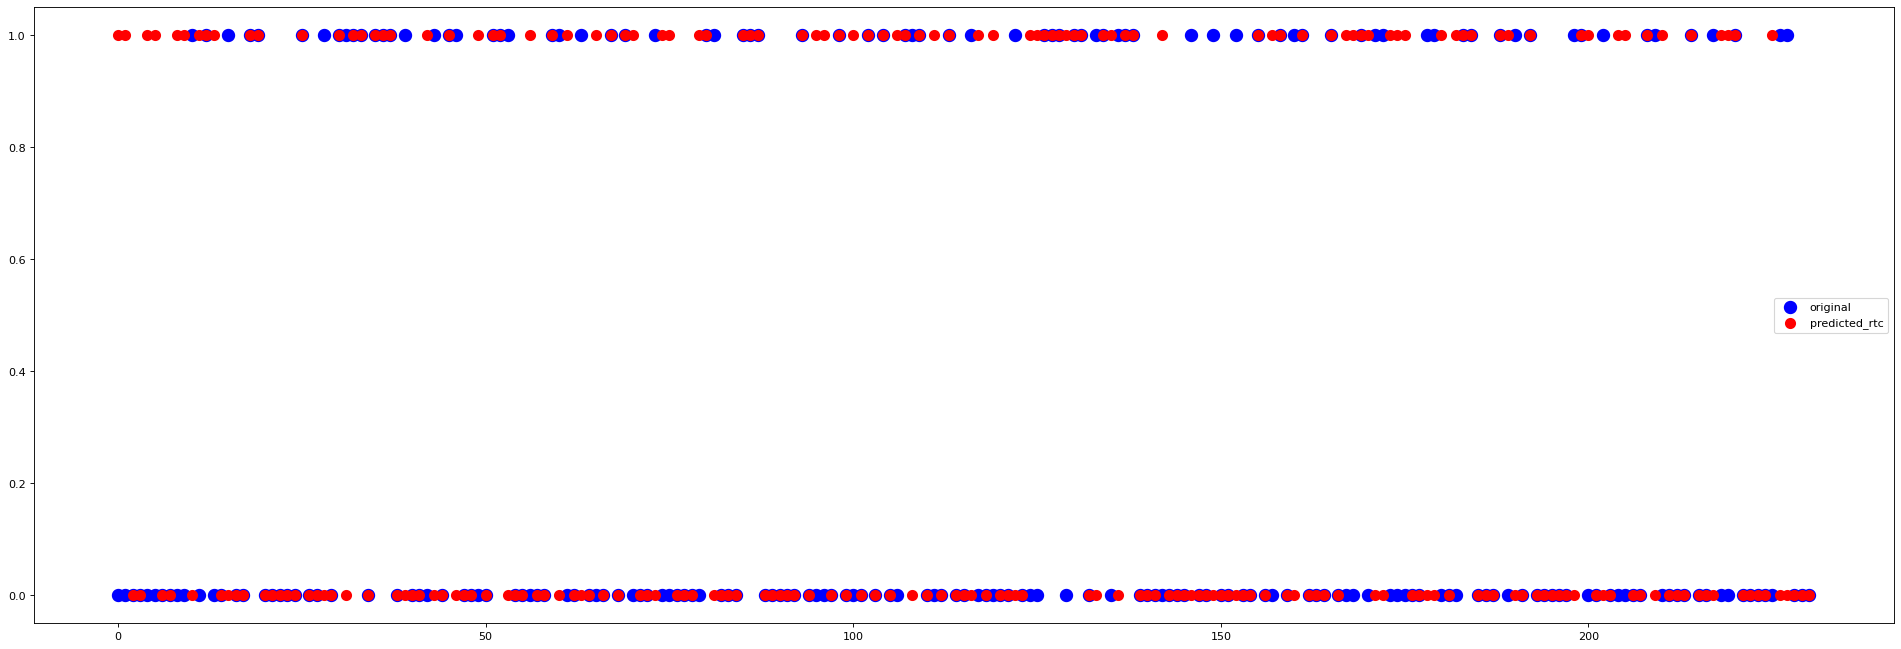

accuracy_score_train:  537
accuracy_score_test:  160
f1_score_train:  1.0
f1_score_test:  0.6077348066298344
roc_auc_score_train:  1.0
roc_auc_score_test:  0.691432119205298
precision_score_train:  1.0
precision_score_test:  0.5445544554455446
recall_score_train:  1.0
recall_score_test:  0.6875
confusion_matrix_train:  [[349   0]
 [  0 188]]
confusion_matrix_test:  [[105  46]
 [ 25  55]]


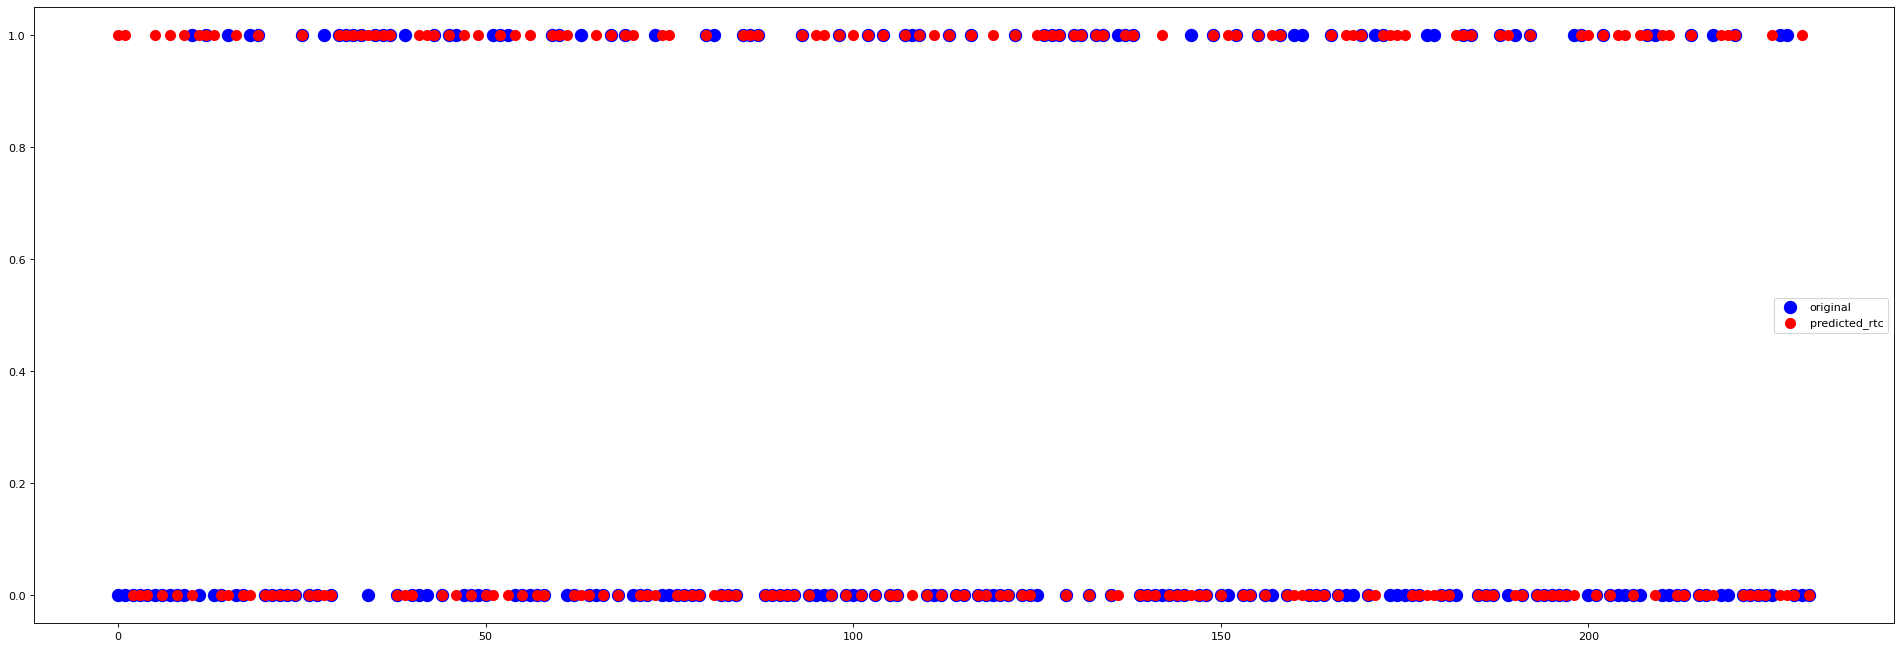

In [ ]:
DTC(X_train_1, y_train_1, X_test_1, y_test_1)
DTC(X_train_2, y_train_2, X_test_2, y_test_2)
DTC(X_train_3, y_train_3, X_test_3, y_test_3)
DTC(X_train_4, y_train_4, X_test_4, y_test_4)
DTC(X_train_5, y_train_5, X_test_5, y_test_5)
DTC(X_train_6, y_train_6, X_test_6, y_test_6)

In [ ]:
# Decision treede de random foresttaki sonuçlara benzer olarak overfit görüldü. Bu durum ağaç temelli algoritmaların aşırı ezberlemeye yatkın olmalarından kaynaklanıyor olabilir.

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters_xgb = {
        'n_estimators': [50,100,200,300,500],
        'subsample': [0, 0.5, 1], 
        'gamma' : [0, 1, 3, 6],
        'max_depth': [3, 4, 5], 
        'learning_rate': [0.001, 0.005, 0.1, 0.05],
        }

In [ ]:
def XGB_2(X_train, y_train, X_test, y_test):
  xgboost = XGBClassifier(objective='reg:squarederror')
  xgboost_cv = GridSearchCV(xgboost, parameters_xgb, cv = 4, verbose = 3)
  xgboost_cv.fit(X_train, y_train)
  best = xgboost_cv.best_params_
  best_values = best.values()
  best_values_list = list(best_values)
  xgboost = XGBClassifier(gamma = best_values_list[0],
                         learning_rate = best_values_list[1],
                         max_depth = best_values_list[2],
                         n_estimators = best_values_list[3],
                         subsample = best_values_list[4])
  xgb_tuned =  xgboost.fit(X_train, y_train) 

  #Metrics
  accuracy_score_train = accuracy_score(y_train, train_preds, normalize=False)
  accuracy_score_test = accuracy_score(y_test, test_preds, normalize=False)
  print("accuracy_score_train: ", accuracy_score_train)
  print("accuracy_score_test: ", accuracy_score_test)

  f1_score_train = f1_score(y_train, train_preds, average='binary')
  f1_score_test = f1_score(y_test, test_preds, average='binary')
  print("f1_score_train: ", f1_score_train)
  print("f1_score_test: ", f1_score_test)

  roc_auc_score_train = roc_auc_score(y_train, train_preds)
  roc_auc_score_test = roc_auc_score(y_test, test_preds)
  print("roc_auc_score_train: ", roc_auc_score_train)
  print("roc_auc_score_test: ", roc_auc_score_test)

  precision_score_train = precision_score(y_train, train_preds, average='binary')
  precision_score_test = precision_score(y_test, test_preds, average='binary')
  print("precision_score_train: ", precision_score_train)
  print("precision_score_test: ", precision_score_test)

  recall_score_train = recall_score(y_train, train_preds, average='binary')
  recall_score_test = recall_score(y_test, test_preds, average='binary')
  print("recall_score_train: ", recall_score_train)
  print("recall_score_test: ", recall_score_test)

  confusion_matrix_train = confusion_matrix(y_train, train_preds)
  confusion_matrix_test = confusion_matrix(y_test, test_preds)
  print("confusion_matrix_train: ", confusion_matrix_train)
  print("confusion_matrix_test: ", confusion_matrix_test)

  predVisualization(test_preds, y_test)

Fitting 4 folds for each of 720 candidates, totalling 2880 fits
[CV] gamma=0, learning_rate=0.001, max_depth=3, n_estimators=50, subsample=0 
[CV]  gamma=0, learning_rate=0.001, max_depth=3, n_estimators=50, subsample=0, score=0.652, total=   0.0s
[CV] gamma=0, learning_rate=0.001, max_depth=3, n_estimators=50, subsample=0 
[CV]  gamma=0, learning_rate=0.001, max_depth=3, n_estimators=50, subsample=0, score=0.649, total=   0.0s
[CV] gamma=0, learning_rate=0.001, max_depth=3, n_estimators=50, subsample=0 
[CV]  gamma=0, learning_rate=0.001, max_depth=3, n_estimators=50, subsample=0, score=0.649, total=   0.0s
[CV] gamma=0, learning_rate=0.001, max_depth=3, n_estimators=50, subsample=0 
[CV]  gamma=0, learning_rate=0.001, max_depth=3, n_estimators=50, subsample=0, score=0.649, total=   0.0s
[CV] gamma=0, learning_rate=0.001, max_depth=3, n_estimators=50, subsample=0.5 
[CV]  gamma=0, learning_rate=0.001, max_depth=3, n_estimators=50, subsample=0.5, score=0.815, total=   0.0s
[CV] gamma=0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


Görüntülenen çıkış son 5000 satıra kısaltıldı.
[CV] gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1 
[CV]  gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1, score=0.800, total=   0.0s
[CV] gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1 
[CV]  gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1, score=0.724, total=   0.0s
[CV] gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1 
[CV]  gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1, score=0.731, total=   0.0s
[CV] gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1 
[CV]  gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1, score=0.746, total=   0.0s
[CV] gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0 
[CV]  gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0, score=0.652, total=   0.0s
[CV] gamma=0, learning_rate=0.1, max_depth=

[Parallel(n_jobs=1)]: Done 2880 out of 2880 | elapsed:  3.7min finished


accuracy_score_train:  420
accuracy_score_test:  170
f1_score_train:  0.6507462686567165
f1_score_test:  0.6211180124223602
roc_auc_score_train:  0.7354523562762909
roc_auc_score_test:  0.7098509933774835
precision_score_train:  0.7414965986394558
precision_score_test:  0.6172839506172839
recall_score_train:  0.5797872340425532
recall_score_test:  0.625
confusion_matrix_train:  [[311  38]
 [ 79 109]]
confusion_matrix_test:  [[120  31]
 [ 30  50]]


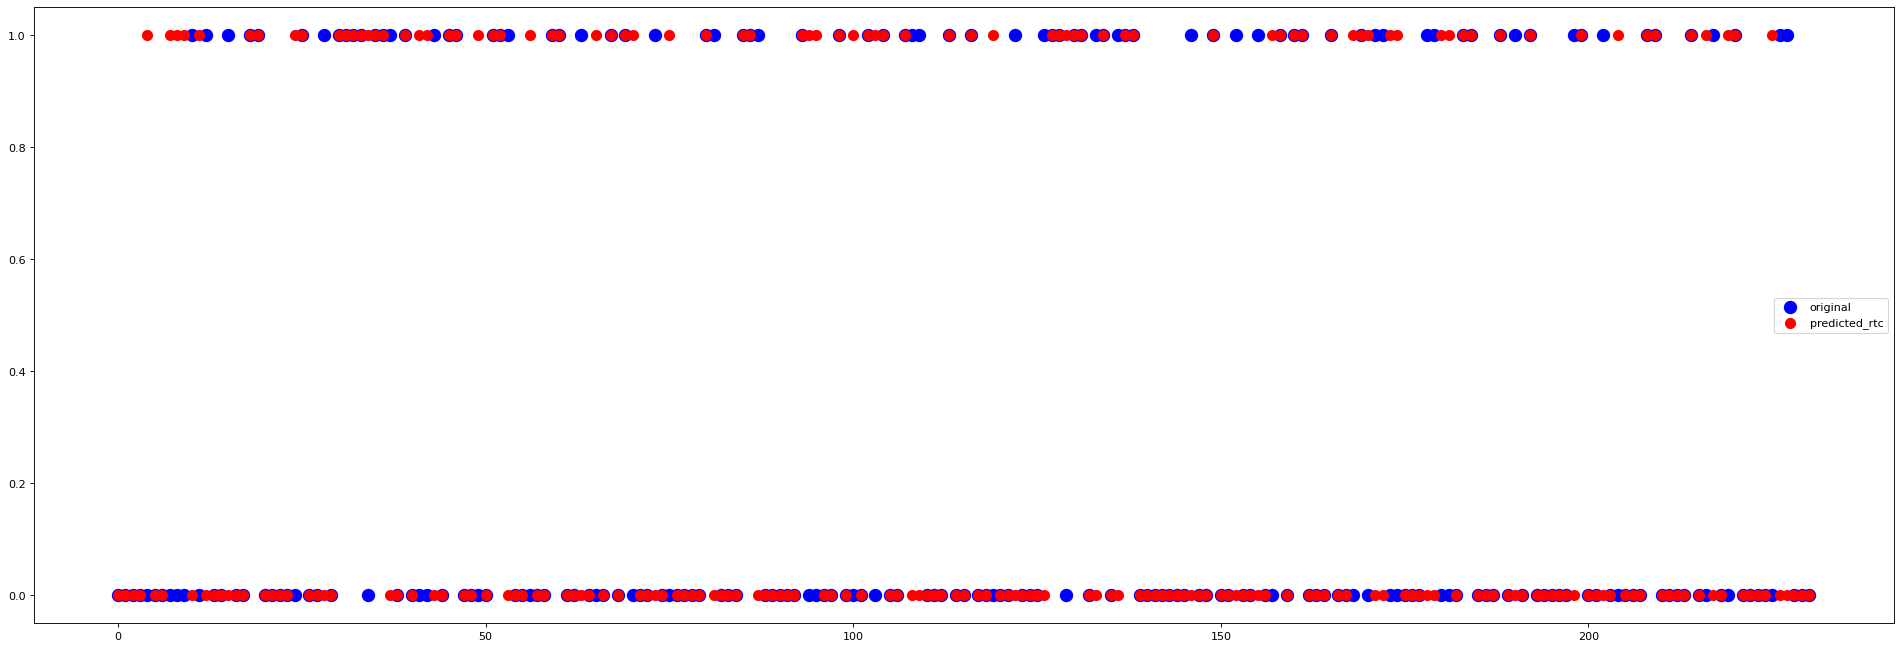

In [ ]:
XGB_2(X_train_4, y_train_4, X_test_4, y_test_4)

In [ ]:
# GridSheach ile default ayarşara göre daha düşük sonuçlar elde edildi. Bunun nedeni cv ile farklı verilerin kullanılması olabilir?

In [ ]:
# Default parametreler ile en iyi (optimum) sonucu XGBoost vermekte. RandomForest ve Decision Tree daha iyi sonuçlar veriyor gibi görünse de pverfitting problemi nednei ile seçilmediler.